In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.cross_decomposition import PLSRegression
from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from scipy.optimize import curve_fit
from scipy import stats

import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, current_dir) 
import raw_dataloader as dl
import bandpower


# Import data

In [4]:
X, Y_class, Y_reg, channels = dl.read_data([1,2,3], range(11), 'class', rm_baseline=True)
    
# Adopt STFT and save file
freq, t, Zxx  = bandpower.STFT(X, Y_reg, channels, 2, 30, './Ginny_ERSP/ERSP_from_raw_rb.data')

# Read pickle file
with open('./ERSP_from_raw.data', 'rb') as fp:
    dict_ERSP = pickle.load(fp)
    
ERSP, SLs, freq, t = dict_ERSP['ERSP'], dict_ERSP['SLs'], dict_ERSP['freq'], dict_ERSP['t']
print('Shape of ERSP: ', ERSP.shape)
print('Shape of SLs: ', SLs.shape)
print('Shape of freq: ', freq.shape)
print('Shape of t: ', t.shape)

After removing outliers, X shape:  (1084, 12, 512)
Arrange all the channels as the same order

Mean of all trials: 13.218015
--- STFT ---

Transform to dB
2 - 30 Hz: 57 steps
Shape of ERSP:  (1084, 12, 57, 172)
Shape of SLs:  (1084,)
Shape of freq:  (57,)
Shape of t:  (172,)


# Regression

In [2]:
def standard_error(pred, target):
    
    assert pred.shape[0] == target.shape[0]
    
    return (np.sum( np.power(pred-target,2) )/len(pred))**0.5

def plot_scatter(true, pred, fileName=None):

    sort_indices = np.argsort(true)
    fig, axs = plt.subplots(1,2, figsize=(8,4))
    axs[0].plot(range(len(true)), true[sort_indices], 'r.', range(len(true)), pred[sort_indices], 'b.')
    axs[0].set_xlabel('Record number')
    axs[0].set_ylabel('Solution latency')
    axs[0].legend(('True', 'Pred'))
    
    max_value = np.max(np.hstack((true, pred)))
    axs[1].scatter(true, pred, marker='.')
    axs[1].set_xlabel('True')
    axs[1].set_ylabel('Pred')
    axs[1].set_xlim([0, max_value])
    axs[1].set_ylim([0, max_value])
    
    if fileName is not None:
        fig.suptitle(fileName)
        plt.savefig('./results/%s.png'%(fileName))
    
def regression(X_train, Y_train, X_test, Y_test, regressor):
    
    results = regressor.fit(X_train,Y_train)
    pred_train = regressor.predict(X_train)
    pred_test = regressor.predict(X_test)
    
    train_std = mean_squared_error(Y_train, pred_train)**0.5
    test_std = mean_squared_error(Y_test, pred_test)**0.5
    train_r2 = r2_score(Y_train, pred_train)
    test_r2 = r2_score(Y_test, pred_test)
    
    return results, train_std, test_std, train_r2, test_r2, pred_train, pred_test

In [18]:
mode_cv = 'LOO'
if mode_cv == 'KFold':
    num_fold = 10
    kf = KFold(n_splits=num_fold, shuffle=True)
else:
    num_fold = ERSP.shape[0]
    kf = LeaveOneOut()
    pred_Y = np.zeros(num_fold)

train_std = np.zeros(num_fold)
test_std = np.zeros(num_fold)
train_r2 = np.zeros(num_fold)
test_r2 = np.zeros(num_fold)
train_base = np.zeros(num_fold)
test_base = np.zeros(num_fold)
train_base_r2 = np.zeros(num_fold)
test_base_r2 = np.zeros(num_fold)

method = 2
select = []

for i, (train_index, test_index) in enumerate(kf.split(ERSP)):
    print('---Iteration %d---\n'%(i))
    #print(test_index)
    
    # Standardize data
    X_all, Y = preprocessing.standardize(ERSP, SLs, train_indices=train_index)
    
    '''
    # Select correlated ERSP
    X_all, select_indices = preprocessing.select_correlated_ERSP(X_all, Y, threshold_corr=0.75, train_indices=train_index)
    select.append(select_indices)
    '''
    # Flatten X_all
    X_all = X_all.reshape((X_all.shape[0],-1))
    
    #X_all = preprocessing.bandpower(X_all, freqs, 5, 15)
    
    # Split data
    X_train, X_test = X_all[train_index, :], X_all[test_index, :]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    if method == 1:
        pca = PCA(n_components=0.9)
        pca.fit(X_train)
        X_train = pca.transform(X_train)
        X_test = pca.transform(X_test)
    elif method == 2:
        # PCA
        X_train, X_test = preprocessing.PCA_corr(X_train, Y_train, X_test=X_test, num_features=5)
    
    # 1. Regression directly
    #rgr = svm.SVR()
    #rgr = Ridge(alpha=1)
    rgr = LinearRegression()
    results, train_std[i], test_std[i], train_r2[i], test_r2[i], pred_train1, pred_test1 = regression(\
        X_train, Y_train, X_test, Y_test, rgr)
    print('Method 1: %f | %f\n'%(train_std[i], test_std[i]))
    if mode_cv == 'LOO':
        pred_Y[i] = pred_test1
    
    train_baseline = np.array([np.mean(Y_train)]*Y_train.shape[0])
    test_baseline = np.array([np.mean(Y_train)]*Y_test.shape[0])
    print('Baseline: %f | %f\n'%(standard_error(train_baseline, Y_train), standard_error(test_baseline, Y_test)))
    train_base[i] = standard_error(train_baseline, Y_train)
    test_base[i] = standard_error(test_baseline, Y_test)
    train_base_r2[i] = r2_score(Y_train, train_baseline)
    test_base_r2[i] = r2_score(Y_test, test_baseline)
    

---Iteration 0---

Base threshold: 1.5273
1. 0.241
2. 0.229
3. 0.201
4. 0.171
5. 0.171
Method 1: 5.727637 | 1.677529

Baseline: 6.440803 | 1.503884

---Iteration 1---

Base threshold: 1.5273
1. 0.240
2. 0.206
3. 0.187
4. 0.171
5. 0.168
Method 1: 5.784420 | 1.400579

Baseline: 6.438440 | 2.749323

---Iteration 2---

Base threshold: 1.5273
1. 0.202
2. 0.175
3. 0.171
4. 0.162
5. 0.152
Method 1: 5.934678 | 1.193085

Baseline: 6.438043 | 2.906476

---Iteration 3---

Base threshold: 1.5273
1. 0.250
2. 0.178
3. 0.175
4. 0.170
5. 0.163
Method 1: 5.828490 | 3.443295

Baseline: 6.437731 | 3.024341

---Iteration 4---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.5273
1. 0.246
2. 0.212
3. 0.191
4. 0.168
5. 0.168
Method 1: 5.766136 | 1.978928

Baseline: 6.441099 | 1.264225

---Iteration 5---

Base threshold: 1.5273
1. 0.223
2. 0.204
3. 0.199
4. 0.181
5. 0.180
Method 1: 5.772514 | 2.169493

Baseline: 6.438676 | 2.651102

---Iteration 6---

Base threshold: 1.5273
1. 0.214
2. 0.206
3. 0.194
4. 0.177
5. 0.176
Method 1: 5.798851 | 4.302905

Baseline: 6.437001 | 3.283643

---Iteration 7---

Base threshold: 1.5273
1. 0.245
2. 0.184
3. 0.183
4. 0.181
5. 0.173


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Method 1: 5.794748 | 1.183473

Baseline: 6.440830 | 1.484240

---Iteration 8---

Base threshold: 1.5273
1. 0.276
2. 0.223
3. 0.173
4. 0.173
5. 0.156
Method 1: 5.721049 | 1.928636

Baseline: 6.436989 | 3.287572

---Iteration 9---

Base threshold: 1.5273
1. 0.255
2. 0.228
3. 0.172
4. 0.170
5. 0.156
Method 1: 5.761871 | 1.815587

Baseline: 6.441017 | 1.334944

---Iteration 10---

Base threshold: 1.5273
1. 0.243
2. 0.220
3. 0.207
4. 0.180
5. 0.173
Method 1: 5.714784 | 3.585365

Baseline: 6.439465 | 2.293578

---Iteration 11---

Base threshold: 1.5273
1. 0.246
2. 0.205
3. 0.178
4. 0.170
5. 0.160


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Method 1: 5.799724 | 1.807715

Baseline: 6.439761 | 2.144283

---Iteration 12---

Base threshold: 1.5273
1. 0.241
2. 0.214
3. 0.175
4. 0.171
5. 0.156
Method 1: 5.806312 | 2.009632

Baseline: 6.441771 | 0.305591

---Iteration 13---

Base threshold: 1.5273
1. 0.249
2. 0.203
3. 0.193
4. 0.192
5. 0.186
Method 1: 5.716975 | 0.226784

Baseline: 6.440975 | 1.370303

---Iteration 14---

Base threshold: 1.5273
1. 0.244
2. 0.222
3. 0.216
4. 0.169
5. 0.157
Method 1: 5.725765 | 1.837380

Baseline: 6.437635 | 3.059700

---Iteration 15---

Base threshold: 1.5273
1. 0.226
2. 0.215
3. 0.200
4. 0.176
5. 0.174
Method 1: 5.764565 | 1.941812

Baseline: 6.437656 | 3.051842

---Iteration 16---

Base threshold: 1.5273


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

1. 0.246
2. 0.235
3. 0.211
4. 0.185
5. 0.170
Method 1: 5.674644 | 2.711094

Baseline: 6.436732 | 3.374007

---Iteration 17---

Base threshold: 1.5273
1. 0.247
2. 0.199
3. 0.198
4. 0.172
5. 0.159
Method 1: 5.776185 | 3.796687

Baseline: 6.436931 | 3.307216

---Iteration 18---

Base threshold: 1.5273
1. 0.254
2. 0.213
3. 0.176
4. 0.168
5. 0.157
Method 1: 5.778067 | 3.232904

Baseline: 6.436148 | 3.562590

---Iteration 19---

Base threshold: 1.5273
1. 0.211
2. 0.211
3. 0.187
4. 0.182
5. 0.182
Method 1: 5.792917 | 1.799496

Baseline: 6.438194 | 2.847543

---Iteration 20---

Base threshold: 1.5273
1. 0.274
2. 0.189
3. 0.188
4. 0.186
5. 0.171
Method 1: 5.724378 | 5.740820

Baseline: 6.439553 | 2.250361

---Iteration 21---

Base threshold: 1.5273


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

1. 0.244
2. 0.235
3. 0.198
4. 0.176
5. 0.167
Method 1: 5.711702 | 4.745267

Baseline: 6.438526 | 2.713963

---Iteration 22---

Base threshold: 1.5273
1. 0.259
2. 0.218
3. 0.193
4. 0.172
5. 0.170
Method 1: 5.721775 | 1.094612

Baseline: 6.439930 | 2.053920

---Iteration 23---

Base threshold: 1.5273
1. 0.251
2. 0.245
3. 0.197
4. 0.181
5. 0.169
Method 1: 5.676311 | 4.850876

Baseline: 6.441300 | 1.071712

---Iteration 24---

Base threshold: 1.5273
1. 0.250
2. 0.232
3. 0.192
4. 0.175
5. 0.174
Method 1: 5.704944 | 3.795881

Baseline: 6.435754 | 3.684384

---Iteration 25---

Base threshold: 1.5273
1. 0.264
2. 0.201
3. 0.171
4. 0.166
5. 0.165
Method 1: 5.777348 | 1.700782

Baseline: 6.437001 | 3.283643

---Iteration 26---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.5273
1. 0.265
2. 0.227
3. 0.191
4. 0.171
5. 0.163
Method 1: 5.707156 | 2.687942

Baseline: 6.437115 | 3.244355

---Iteration 27---

Base threshold: 1.5273
1. 0.264
2. 0.202
3. 0.178
4. 0.168
5. 0.168
Method 1: 5.762169 | 3.288907

Baseline: 6.435611 | 3.727601

---Iteration 28---

Base threshold: 1.5273
1. 0.259
2. 0.250
3. 0.185
4. 0.173
5. 0.153
Method 1: 5.695153 | 3.036418

Baseline: 6.436060 | 3.590092

---Iteration 29---

Base threshold: 1.5273
1. 0.234
2. 0.222
3. 0.203
4. 0.175
5. 0.174
Method 1: 5.734339 | 0.191574

Baseline: 6.435702 | 3.700099

---Iteration 30---

Base threshold: 1.5273
1. 0.201
2. 0.199
3. 0.185
4. 0.174
5. 0.165
Method 1: 5.858989 | 2.881022

Baseline: 6.437613 | 3.067558

---Iteration 31---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.5273
1. 0.228
2. 0.221
3. 0.195
4. 0.175
5. 0.162
Method 1: 5.775477 | 0.921909

Baseline: 6.440717 | 1.566745

---Iteration 32---

Base threshold: 1.5273
1. 0.218
2. 0.187
3. 0.183
4. 0.177
5. 0.167
Method 1: 5.845514 | 2.267245

Baseline: 6.436493 | 3.452583

---Iteration 33---

Base threshold: 1.5273
1. 0.253
2. 0.219
3. 0.204
4. 0.175
5. 0.172
Method 1: 5.710489 | 4.000380

Baseline: 6.439327 | 2.360368

---Iteration 34---

Base threshold: 1.5273
1. 0.243
2. 0.206
3. 0.203
4. 0.186
5. 0.172
Method 1: 5.731758 | 2.712573

Baseline: 6.436297 | 3.515444

---Iteration 35---

Base threshold: 1.5273
1. 0.225
2. 0.224
3. 0.179
4. 0.172
5. 0.167
Method 1: 5.792893 | 0.522974

Baseline: 6.438254 | 2.823970

---Iteration 36---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.5273
1. 0.265
2. 0.218
3. 0.194
4. 0.174
5. 0.173
Method 1: 5.702299 | 1.976551

Baseline: 6.438449 | 2.745394

---Iteration 37---

Base threshold: 1.5273
1. 0.228
2. 0.201
3. 0.189
4. 0.174
5. 0.167
Method 1: 5.803127 | 1.991989

Baseline: 6.434400 | 4.075054

---Iteration 38---

Base threshold: 1.5273
1. 0.258
2. 0.231
3. 0.188
4. 0.172
5. 0.157
Method 1: 5.724144 | 2.280473

Baseline: 6.439887 | 2.077493

---Iteration 39---

Base threshold: 1.5273
1. 0.259
2. 0.211
3. 0.191
4. 0.174
5. 0.170
Method 1: 5.731371 | 2.450341

Baseline: 6.438464 | 2.739252

---Iteration 40---

Base threshold: 1.5273
1. 0.252
2. 0.198
3. 0.190
4. 0.187
5. 0.172
Method 1: 5.748780 | 2.569528

Baseline: 6.440637 | 1.623465

---Iteration 41---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.5273
1. 0.229
2. 0.200
3. 0.180
4. 0.170
5. 0.156
Method 1: 5.835151 | 5.297286

Baseline: 6.437104 | 3.248284

---Iteration 42---

Base threshold: 1.5273
1. 0.281
2. 0.244
3. 0.175
4. 0.171
5. 0.160
Method 1: 5.672551 | 0.088689

Baseline: 6.440126 | 1.943913

---Iteration 43---

Base threshold: 1.5273
1. 0.210
2. 0.198
3. 0.188
4. 0.174
5. 0.173
Method 1: 5.832573 | 2.940346

Baseline: 6.437868 | 2.973266

---Iteration 44---

Base threshold: 1.5273
1. 0.250
2. 0.237
3. 0.177
4. 0.170
5. 0.164
Method 1: 5.729640 | 2.742764

Baseline: 6.429981 | 5.147625

---Iteration 45---

Base threshold: 1.5273
1. 0.210
2. 0.199
3. 0.199
4. 0.192
5. 0.180
Method 1: 5.787297 | 1.765963

Baseline: 6.440552 | 1.680681

---Iteration 46---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.5273
1. 0.251
2. 0.223
3. 0.173
4. 0.172
5. 0.171
Method 1: 5.754395 | 0.864432

Baseline: 6.441598 | 0.692332

---Iteration 47---

Base threshold: 1.5273
1. 0.273
2. 0.214
3. 0.172
4. 0.170
5. 0.156
Method 1: 5.737124 | 5.330651

Baseline: 6.426790 | 5.799810

---Iteration 48---

Base threshold: 1.5273
1. 0.247
2. 0.199
3. 0.199
4. 0.192
5. 0.186
Method 1: 5.717307 | 3.391213

Baseline: 6.439327 | 2.360368

---Iteration 49---

Base threshold: 1.5273
1. 0.285
2. 0.236
3. 0.208
4. 0.191
5. 0.173
Method 1: 5.584986 | 3.573785

Baseline: 6.435806 | 3.668669

---Iteration 50---

Base threshold: 1.5273
1. 0.240
2. 0.202
3. 0.200
4. 0.183
5. 0.158
Method 1: 5.771037 | 0.165502

Baseline: 6.438254 | 2.823970

---Iteration 51---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.5273
1. 0.211
2. 0.199
3. 0.179
4. 0.172
5. 0.170
Method 1: 5.797236 | 9.374691

Baseline: 6.382336 | 11.520186

---Iteration 52---

Base threshold: 1.5273
1. 0.227
2. 0.190
3. 0.189
4. 0.183
5. 0.180
Method 1: 5.794990 | 4.944078

Baseline: 6.436383 | 3.487943

---Iteration 53---

Base threshold: 1.5273
1. 0.235
2. 0.225
3. 0.169
4. 0.162
5. 0.156
Method 1: 5.814060 | 1.941432

Baseline: 6.440318 | 1.829977

---Iteration 54---

Base threshold: 1.5273
1. 0.247
2. 0.199
3. 0.189
4. 0.177
5. 0.173
Method 1: 5.768800 | 2.525389

Baseline: 6.441072 | 1.287798

---Iteration 55---

Base threshold: 1.5273
1. 0.238
2. 0.226
3. 0.179
4. 0.176
5. 0.157
Method 1: 5.778844 | 0.318710

Baseline: 6.441670 | 0.564893

---Iteration 56---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.5273
1. 0.243
2. 0.230
3. 0.205
4. 0.179
5. 0.172
Method 1: 5.704973 | 4.035840

Baseline: 6.439723 | 2.163927

---Iteration 57---

Base threshold: 1.5273
1. 0.265
2. 0.248
3. 0.189
4. 0.177
5. 0.176
Method 1: 5.652236 | 3.668062

Baseline: 6.439959 | 2.038204

---Iteration 58---

Base threshold: 1.5273
1. 0.212
2. 0.201
3. 0.186
4. 0.186
5. 0.185
Method 1: 5.801696 | 2.257011

Baseline: 6.441531 | 0.794482

---Iteration 59---

Base threshold: 1.5273
1. 0.225
2. 0.215
3. 0.207
4. 0.185
5. 0.173
Method 1: 5.748117 | 2.373541

Baseline: 6.441670 | 0.564893

---Iteration 60---

Base threshold: 1.5273
1. 0.213
2. 0.212
3. 0.200
4. 0.199
5. 0.196
Method 1: 5.712266 | 10.085491

Baseline: 6.419608 | 7.049178

---Iteration 61---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.5273
1. 0.247
2. 0.223
3. 0.194
4. 0.177
5. 0.162
Method 1: 5.740984 | 2.799468

Baseline: 6.441077 | 1.283869

---Iteration 62---

Base threshold: 1.5273
1. 0.248
2. 0.196
3. 0.191
4. 0.179
5. 0.178
Method 1: 5.759900 | 1.833299

Baseline: 6.440550 | 1.682397

---Iteration 63---

Base threshold: 1.5273
1. 0.242
2. 0.196
3. 0.176
4. 0.173
5. 0.171
Method 1: 5.804584 | 4.473703

Baseline: 6.438607 | 2.680320

---Iteration 64---

Base threshold: 1.5273
1. 0.245
2. 0.218
3. 0.199
4. 0.172
5. 0.169
Method 1: 5.742043 | 2.043790

Baseline: 6.440625 | 1.631322

---Iteration 65---

Base threshold: 1.5273
1. 0.258
2. 0.213
3. 0.183
4. 0.181
5. 0.165
Method 1: 5.738481 | 2.463256

Baseline: 6.439120 | 2.456376

---Iteration 66---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.5273
1. 0.246
2. 0.199
3. 0.198
4. 0.181
5. 0.171
Method 1: 5.755975 | 0.695055

Baseline: 6.440916 | 1.417449

---Iteration 67---

Base threshold: 1.5273
1. 0.224
2. 0.211
3. 0.186
4. 0.181
5. 0.173
Method 1: 5.791267 | 0.186426

Baseline: 6.441789 | 0.228730

---Iteration 68---

Base threshold: 1.5273
1. 0.249
2. 0.216
3. 0.178
4. 0.176
5. 0.173
Method 1: 5.753244 | 1.710090

Baseline: 6.437847 | 2.981124

---Iteration 69---

Base threshold: 1.5273
1. 0.202
2. 0.194
3. 0.193
4. 0.187
5. 0.179
Method 1: 5.824787 | 1.052269

Baseline: 6.441177 | 1.193506

---Iteration 70---

Base threshold: 1.5273
1. 0.235
2. 0.216
3. 0.194
4. 0.184
5. 0.175
Method 1: 5.741912 | 1.918214

Baseline: 6.436210 | 3.542946

---Iteration 71---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.5273
1. 0.227
2. 0.215
3. 0.180
4. 0.176
5. 0.172
Method 1: 5.789366 | 5.011002

Baseline: 6.436493 | 3.452583

---Iteration 72---

Base threshold: 1.5273
1. 0.256
2. 0.206
3. 0.173
4. 0.151
5. 0.149
Method 1: 5.821327 | 1.697113

Baseline: 6.440850 | 1.468524

---Iteration 73---

Base threshold: 1.5273
1. 0.246
2. 0.246
3. 0.194
4. 0.193
5. 0.177
Method 1: 5.656992 | 0.975249

Baseline: 6.435921 | 3.633309

---Iteration 74---

Base threshold: 1.5273
1. 0.216
2. 0.198
3. 0.183
4. 0.176
5. 0.170
Method 1: 5.835110 | 0.055977

Baseline: 6.439887 | 2.077493

---Iteration 75---

Base threshold: 1.5273
1. 0.194
2. 0.185
3. 0.180
4. 0.173
5. 0.166
Method 1: 5.896865 | 4.849502

Baseline: 6.440499 | 1.716040

---Iteration 76---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.5273
1. 0.207
2. 0.206
3. 0.189
4. 0.182
5. 0.160
Method 1: 5.832705 | 0.336872

Baseline: 6.440082 | 1.969202

---Iteration 77---

Base threshold: 1.5273
1. 0.247
2. 0.213
3. 0.173
4. 0.171
5. 0.157
Method 1: 5.793811 | 3.928526

Baseline: 6.437868 | 2.973266

---Iteration 78---

Base threshold: 1.5273
1. 0.249
2. 0.215
3. 0.185
4. 0.181
5. 0.172
Method 1: 5.739573 | 2.806629

Baseline: 6.436720 | 3.377935

---Iteration 79---

Base threshold: 1.5273
1. 0.227
2. 0.186
3. 0.186
4. 0.177
5. 0.173
Method 1: 5.801009 | 7.436998

Baseline: 6.414453 | 7.823158

---Iteration 80---

Base threshold: 1.5273
1. 0.251
2. 0.223
3. 0.187
4. 0.176
5. 0.174
Method 1: 5.727150 | 0.104702

Baseline: 6.438644 | 2.664604

---Iteration 81---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.5273
1. 0.245
2. 0.213
3. 0.174
4. 0.168
5. 0.166
Method 1: 5.791362 | 0.918629

Baseline: 6.441518 | 0.812410

---Iteration 82---

Base threshold: 1.5273
1. 0.262
2. 0.247
3. 0.174
4. 0.161
5. 0.156
Method 1: 5.723295 | 2.855987

Baseline: 6.439795 | 2.126355

---Iteration 83---

Base threshold: 1.5273
1. 0.247
2. 0.231
3. 0.195
4. 0.176
5. 0.157
Method 1: 5.733145 | 1.480231

Baseline: 6.441372 | 0.993136

---Iteration 84---

Base threshold: 1.5273
1. 0.253
2. 0.227
3. 0.209
4. 0.170
5. 0.166
Method 1: 5.701326 | 4.946178

Baseline: 6.438497 | 2.725750

---Iteration 85---

Base threshold: 1.5273
1. 0.278
2. 0.231
3. 0.174
4. 0.163
5. 0.161
Method 1: 5.708202 | 4.226645

Baseline: 6.436826 | 3.342576

---Iteration 86---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.5273
1. 0.253
2. 0.210
3. 0.209
4. 0.178
5. 0.174
Method 1: 5.707272 | 5.531270

Baseline: 6.436297 | 3.515444

---Iteration 87---

Base threshold: 1.5273
1. 0.255
2. 0.174
3. 0.157
4. 0.156
5. 0.156
Method 1: 5.868778 | 2.641184

Baseline: 6.437070 | 3.260070

---Iteration 88---

Base threshold: 1.5273
1. 0.228
2. 0.199
3. 0.173
4. 0.172
5. 0.171
Method 1: 5.827085 | 5.531587

Baseline: 6.436529 | 3.440797

---Iteration 89---

Base threshold: 1.5273
1. 0.277
2. 0.203
3. 0.195
4. 0.167
5. 0.167
Method 1: 5.714668 | 3.030501

Baseline: 6.437624 | 3.063629

---Iteration 90---

Base threshold: 1.5273


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

1. 0.202
2. 0.195
3. 0.183
4. 0.179
5. 0.178
Method 1: 5.847007 | 2.760968

Baseline: 6.439654 | 2.199286

---Iteration 91---

Base threshold: 1.5273
1. 0.214
2. 0.207
3. 0.201
4. 0.183
5. 0.171
Method 1: 5.791948 | 1.765208

Baseline: 6.441749 | 0.378026

---Iteration 92---

Base threshold: 1.5273
1. 0.252
2. 0.250
3. 0.218
4. 0.172
5. 0.158
Method 1: 5.659736 | 0.380088

Baseline: 6.441581 | 0.719834

---Iteration 93---

Base threshold: 1.5273
1. 0.250
2. 0.227
3. 0.184
4. 0.166
5. 0.160
Method 1: 5.758538 | 1.163998

Baseline: 6.439481 | 2.285721

---Iteration 94---

Base threshold: 1.5273
1. 0.205
2. 0.204
3. 0.193
4. 0.190
5. 0.175
Method 1: 5.800066 | 1.693905

Baseline: 6.435676 | 3.707957

---Iteration 95---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.5273
1. 0.251
2. 0.209
3. 0.179
4. 0.178
5. 0.173
Method 1: 5.760553 | 0.730766

Baseline: 6.440106 | 1.955699

---Iteration 96---

Base threshold: 1.5273
1. 0.250
2. 0.204
3. 0.197
4. 0.191
5. 0.175
Method 1: 5.725379 | 1.494980

Baseline: 6.440616 | 1.637464

---Iteration 97---

Base threshold: 1.5273
1. 0.268
2. 0.245
3. 0.182
4. 0.152
5. 0.145
Method 1: 5.727914 | 3.246969

Baseline: 6.441812 | 0.018786

---Iteration 98---

Base threshold: 1.5273
1. 0.210
2. 0.203
3. 0.167
4. 0.158
5. 0.154
Method 1: 5.894665 | 4.533231

Baseline: 6.438134 | 2.871116

---Iteration 99---

Base threshold: 1.5273
1. 0.244
2. 0.203
3. 0.196
4. 0.183
5. 0.174
Method 1: 5.748981 | 2.877485

Baseline: 6.438164 | 2.859330

---Iteration 100---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.5273
1. 0.261
2. 0.244
3. 0.193
4. 0.175
5. 0.174
Method 1: 5.666104 | 0.399581

Baseline: 6.440450 | 1.747471

---Iteration 101---

Base threshold: 1.5273
1. 0.235
2. 0.233
3. 0.189
4. 0.172
5. 0.151
Method 1: 5.766023 | 2.413993

Baseline: 6.437138 | 3.236497

---Iteration 102---

Base threshold: 1.5273
1. 0.222
2. 0.221
3. 0.195
4. 0.185
5. 0.172
Method 1: 5.756334 | 3.346156

Baseline: 6.435767 | 3.680455

---Iteration 103---

Base threshold: 1.5273
1. 0.277
2. 0.209
3. 0.196
4. 0.191
5. 0.169
Method 1: 5.675207 | 0.493849

Baseline: 6.441748 | 0.380238

---Iteration 104---

Base threshold: 1.5273
1. 0.242
2. 0.215
3. 0.180
4. 0.175
5. 0.173
Method 1: 5.763722 | 2.890410

Baseline: 6.434837 | 3.953260

---Iteration 105---

Base threshold: 1.5273
1. 0.252
2. 0.222
3. 0.185
4. 0.173
5. 0.172
Method 1: 5.733856 | 5.336520

Baseline: 6.436589 | 3.421152

---Iteration 106---

Base threshold: 1.5273
1. 0.239
2. 0.238
3. 0.173
4. 0.172
5. 0.164
Method 1: 5.758123 | 4.077

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

1. 0.236
2. 0.212
3. 0.198
4. 0.174
5. 0.174
Method 1: 5.754568 | 6.661736

Baseline: 6.435387 | 3.794391

---Iteration 110---

Base threshold: 1.5273
1. 0.254
2. 0.209
3. 0.190
4. 0.183
5. 0.171
Method 1: 5.702463 | 10.816433

Baseline: 6.402684 | 9.351472

---Iteration 111---

Base threshold: 1.5273
1. 0.284
2. 0.189
3. 0.173
4. 0.168
5. 0.160
Method 1: 5.761145 | 0.026526

Baseline: 6.440466 | 1.737401

---Iteration 112---

Base threshold: 1.5273
1. 0.229
2. 0.224
3. 0.183
4. 0.173
5. 0.169
Method 1: 5.779833 | 0.871677

Baseline: 6.438801 | 2.597814

---Iteration 113---

Base threshold: 1.5273
1. 0.244
2. 0.244
3. 0.173
4. 0.149
5. 0.148
Method 1: 5.785063 | 4.269756

Baseline: 6.439441 | 2.305365

---Iteration 114---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.5273
1. 0.235
2. 0.218
3. 0.185
4. 0.178
5. 0.152
Method 1: 5.788127 | 2.044490

Baseline: 6.438686 | 2.647173

---Iteration 115---

Base threshold: 1.5273
1. 0.238
2. 0.217
3. 0.193
4. 0.169
5. 0.168
Method 1: 5.769380 | 2.697274

Baseline: 6.441486 | 0.855627

---Iteration 116---

Base threshold: 1.5273
1. 0.257
2. 0.228
3. 0.173
4. 0.173
5. 0.161
Method 1: 5.749241 | 2.785057

Baseline: 6.441281 | 1.091357

---Iteration 117---

Base threshold: 1.5273
1. 0.245
2. 0.213
3. 0.187
4. 0.171
5. 0.152
Method 1: 5.786548 | 1.587120

Baseline: 6.440771 | 1.527457

---Iteration 118---

Base threshold: 1.5273


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

1. 0.257
2. 0.251
3. 0.179
4. 0.177
5. 0.170
Method 1: 5.683972 | 0.648962

Baseline: 6.440861 | 1.460667

---Iteration 119---

Base threshold: 1.5273
1. 0.227
2. 0.221
3. 0.200
4. 0.173
5. 0.172
Method 1: 5.763034 | 0.489343

Baseline: 6.441752 | 0.366239

---Iteration 120---

Base threshold: 1.5273
1. 0.235
2. 0.212
3. 0.182
4. 0.178
5. 0.175
Method 1: 5.774015 | 4.356090

Baseline: 6.438896 | 2.556810

---Iteration 121---

Base threshold: 1.5273
1. 0.236
2. 0.198
3. 0.186
4. 0.184
5. 0.172
Method 1: 5.786107 | 3.439283

Baseline: 6.440610 | 1.641393

---Iteration 122---

Base threshold: 1.5273
1. 0.248
2. 0.207
3. 0.205
4. 0.174
5. 0.163
Method 1: 5.737044 | 5.145155

Baseline: 6.425115 | 6.114117

---Iteration 123---

Base threshold: 1.5273


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

1. 0.243
2. 0.199
3. 0.174
4. 0.172
5. 0.166
Method 1: 5.806970 | 1.982214

Baseline: 6.435624 | 3.723672

---Iteration 124---

Base threshold: 1.5273
1. 0.243
2. 0.241
3. 0.175
4. 0.170
5. 0.150
Method 1: 5.765035 | 0.375608

Baseline: 6.441769 | 0.311236

---Iteration 125---

Base threshold: 1.5273
1. 0.263
2. 0.246
3. 0.197
4. 0.170
5. 0.169
Method 1: 5.662852 | 3.197587

Baseline: 6.436850 | 3.334718

---Iteration 126---

Base threshold: 1.5273
1. 0.249
2. 0.219
3. 0.189
4. 0.180
5. 0.180
Method 1: 5.722124 | 0.751487

Baseline: 6.440221 | 1.888909

---Iteration 127---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.5273
1. 0.249
2. 0.218
3. 0.189
4. 0.185
5. 0.180
Method 1: 5.671878 | 8.936618

Baseline: 6.389825 | 10.773708

---Iteration 128---

Base threshold: 1.5273
1. 0.232
2. 0.216
3. 0.194
4. 0.173
5. 0.173
Method 1: 5.764369 | 2.389526

Baseline: 6.436897 | 3.319003

---Iteration 129---

Base threshold: 1.5273
1. 0.230
2. 0.181
3. 0.178
4. 0.172
5. 0.156
Method 1: 5.861293 | 4.908373

Baseline: 6.438313 | 2.800397

---Iteration 130---

Base threshold: 1.5273


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

1. 0.243
2. 0.212
3. 0.179
4. 0.169
5. 0.168
Method 1: 5.778585 | 6.066330

Baseline: 6.433817 | 4.232207

---Iteration 131---

Base threshold: 1.5273
1. 0.233
2. 0.230
3. 0.195
4. 0.180
5. 0.155
Method 1: 5.717419 | 8.050030

Baseline: 6.397579 | 9.940797

---Iteration 132---

Base threshold: 1.5273
1. 0.232
2. 0.180
3. 0.174
4. 0.172
5. 0.160
Method 1: 5.858804 | 1.629793

Baseline: 6.437115 | 3.244355

---Iteration 133---

Base threshold: 1.5273
1. 0.246
2. 0.200
3. 0.187
4. 0.166
5. 0.159
Method 1: 5.799982 | 1.893848

Baseline: 6.437878 | 2.969337

---Iteration 134---

Base threshold: 1.5273


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

1. 0.241
2. 0.211
3. 0.193
4. 0.179
5. 0.174
Method 1: 5.749497 | 6.376496

Baseline: 6.436505 | 3.448654

---Iteration 135---

Base threshold: 1.5273
1. 0.235
2. 0.220
3. 0.195
4. 0.182
5. 0.176
Method 1: 5.740285 | 1.754138

Baseline: 6.441643 | 0.615968

---Iteration 136---

Base threshold: 1.5273
1. 0.254
2. 0.253
3. 0.162
4. 0.161
5. 0.161
Method 1: 5.739264 | 1.818599

Baseline: 6.441315 | 1.055997

---Iteration 137---

Base threshold: 1.5273
1. 0.238
2. 0.198
3. 0.181
4. 0.173
5. 0.172
Method 1: 5.802968 | 1.770791

Baseline: 6.439716 | 2.167856

---Iteration 138---

Base threshold: 1.5273
1. 0.250
2. 0.207
3. 0.184
4. 0.179
5. 0.163
Method 1: 5.769635 | 4.252784

Baseline: 6.439746 | 2.152141

---Iteration 139---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.5273
1. 0.265
2. 0.211
3. 0.177
4. 0.175
5. 0.169
Method 1: 5.729773 | 5.816692

Baseline: 6.426667 | 5.823383

---Iteration 140---

Base threshold: 1.5273
1. 0.247
2. 0.193
3. 0.187
4. 0.178
5. 0.161
Method 1: 5.789834 | 1.160676

Baseline: 6.438043 | 2.906476

---Iteration 141---

Base threshold: 1.5273
1. 0.223
2. 0.183
3. 0.166
4. 0.166
5. 0.165
Method 1: 5.523581 | 27.155158

Baseline: 6.046685 | 29.302068

---Iteration 142---

Base threshold: 1.5273
1. 0.247
2. 0.222
3. 0.174
4. 0.164
5. 0.154
Method 1: 5.790246 | 3.968183

Baseline: 6.438583 | 2.690390

---Iteration 143---

Base threshold: 1.5273


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

1. 0.247
2. 0.221
3. 0.195
4. 0.184
5. 0.164
Method 1: 5.435255 | 28.703887

Baseline: 6.108773 | 26.968344

---Iteration 144---

Base threshold: 1.5273
1. 0.293
2. 0.199
3. 0.182
4. 0.171
5. 0.164
Method 1: 5.705483 | 1.218941

Baseline: 6.439028 | 2.497878

---Iteration 145---

Base threshold: 1.5273
1. 0.240
2. 0.227
3. 0.208
4. 0.190
5. 0.172
Method 1: 5.692725 | 4.423706

Baseline: 6.438411 | 2.761109

---Iteration 146---

Base threshold: 1.5273
1. 0.220
2. 0.189
3. 0.188
4. 0.169
5. 0.165
Method 1: 5.603251 | 22.268945

Baseline: 6.169921 | 24.426391

---Iteration 147---

Base threshold: 1.5273
1. 0.247
2. 0.241
3. 0.181
4. 0.174
5. 0.167
Method 1: 5.722144 | 6.354475

Baseline: 6.437183 | 3.220782

---Iteration 148---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.5273
1. 0.273
2. 0.251
3. 0.179
4. 0.174
5. 0.150
Method 1: 5.677551 | 4.089284

Baseline: 6.439327 | 2.360368

---Iteration 149---

Base threshold: 1.5273
1. 0.187
2. 0.182
3. 0.173
4. 0.173
5. 0.165
Method 1: 5.915990 | 5.864815

Baseline: 6.437362 | 3.157921

---Iteration 150---

Base threshold: 1.5273
1. 0.258
2. 0.217
3. 0.177
4. 0.166
5. 0.155
Method 1: 5.523322 | 22.164427

Baseline: 6.161631 | 24.787843

---Iteration 151---

Base threshold: 1.5273
1. 0.238
2. 0.234
3. 0.182
4. 0.175
5. 0.167
Method 1: 5.745038 | 5.732573

Baseline: 6.437741 | 3.020412

---Iteration 152---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.5273
1. 0.291
2. 0.217
3. 0.175
4. 0.164
5. 0.156
Method 1: 5.706688 | 6.232077

Baseline: 6.435266 | 3.829751

---Iteration 153---

Base threshold: 1.5273
1. 0.270
2. 0.215
3. 0.185
4. 0.179
5. 0.174
Method 1: 5.701879 | 2.534454

Baseline: 6.438260 | 2.821758

---Iteration 154---

Base threshold: 1.5273
1. 0.266
2. 0.207
3. 0.197
4. 0.189
5. 0.181
Method 1: 5.683415 | 0.413287

Baseline: 6.439518 | 2.267793

---Iteration 155---

Base threshold: 1.5273
1. 0.247
2. 0.185
3. 0.185
4. 0.174
5. 0.173
Method 1: 5.796015 | 2.720598

Baseline: 6.439028 | 2.497878

---Iteration 156---

Base threshold: 1.5273


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

1. 0.291
2. 0.229
3. 0.202
4. 0.175
5. 0.170
Method 1: 5.624497 | 3.488455

Baseline: 6.441738 | 0.409456

---Iteration 157---

Base threshold: 1.5273
1. 0.210
2. 0.175
3. 0.169
4. 0.167
5. 0.158
Method 1: 5.913431 | 2.212251

Baseline: 6.437024 | 3.275786

---Iteration 158---

Base threshold: 1.5273
1. 0.243
2. 0.217
3. 0.181
4. 0.180
5. 0.166
Method 1: 5.660567 | 15.395976

Baseline: 6.325454 | 16.077628

---Iteration 159---

Base threshold: 1.5273
1. 0.234
2. 0.227
3. 0.208
4. 0.179
5. 0.169
Method 1: 5.718367 | 4.777637

Baseline: 6.435559 | 3.743316

---Iteration 160---

Base threshold: 1.5273
1. 0.247
2. 0.234
3. 0.173
4. 0.172
5. 0.171
Method 1: 5.744410 | 2.029160

Baseline: 6.441496 | 0.841628

---Iteration 161---

Base threshold: 1.5273
1. 0.246
2. 0.178
3. 0.174
4. 0.168
5. 0.166
Method 1: 5.826763 | 5.898400

Baseline: 6.428472 | 5.465860

---Iteration 162---

Base threshold: 1.5273
1. 0.234
2. 0.229
3. 0.172
4. 0.162
5. 0.160
Method 1: 5.799440 | 3.739202

Baseline: 6.4384

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

1. 0.247
2. 0.212
3. 0.201
4. 0.177
5. 0.174
Method 1: 5.733260 | 1.738137

Baseline: 6.440564 | 1.672823

---Iteration 166---

Base threshold: 1.5273
1. 0.246
2. 0.204
3. 0.203
4. 0.194
5. 0.168
Method 1: 5.727291 | 1.562022

Baseline: 6.439392 | 2.328938

---Iteration 167---

Base threshold: 1.5273
1. 0.256
2. 0.211
3. 0.211
4. 0.183
5. 0.178
Method 1: 5.689477 | 0.151787

Baseline: 6.440593 | 1.653179

---Iteration 168---

Base threshold: 1.5273
1. 0.277
2. 0.223
3. 0.172
4. 0.167
5. 0.165
Method 1: 5.718800 | 0.564533

Baseline: 6.441234 | 1.138503

---Iteration 169---

Base threshold: 1.5273
1. 0.250
2. 0.200
3. 0.191
4. 0.184
5. 0.179
Method 1: 5.744088 | 1.413969

Baseline: 6.441273 | 1.099214

---Iteration 170---

Base threshold: 1.5273


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

1. 0.290
2. 0.222
3. 0.208
4. 0.193
5. 0.175
Method 1: 4.554882 | 46.602456

Baseline: 5.241470 | 49.398031

---Iteration 171---

Base threshold: 1.5273
1. 0.277
2. 0.200
3. 0.184
4. 0.183
5. 0.172
Method 1: 5.712008 | 0.685332

Baseline: 6.441811 | 0.048004

---Iteration 172---

Base threshold: 1.5273
1. 0.246
2. 0.226
3. 0.199
4. 0.179
5. 0.173
Method 1: 5.709700 | 6.927389

Baseline: 6.437472 | 3.118633

---Iteration 173---

Base threshold: 1.5273
1. 0.251
2. 0.203
3. 0.188
4. 0.178
5. 0.174
Method 1: 5.756721 | 0.923732

Baseline: 6.441776 | 0.285947



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

In [19]:
print('Baseline : std (%.2f,%.2f), r2 (%.2f,%.2f)'%\
      (np.mean(train_base), np.mean(test_base), np.mean(train_base_r2), np.mean(test_base_r2)))
print('Method 1: std (%.2f,%.2f), r2 (%.2f,%.2f)'%(np.mean(train_std), np.mean(test_std), np.mean(train_r2), np.mean(test_r2)))

Baseline : std (6.42,3.59), r2 (0.00,nan)
Method 1: std (5.74,3.76), r2 (0.20,nan)


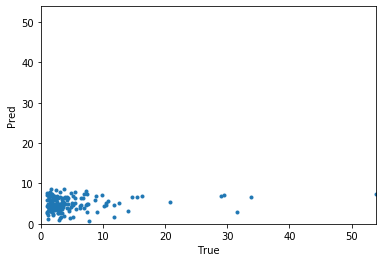

In [20]:
if mode_cv == 'KFold':
    plot_scatter(Y_test, pred_test1)
else:
    plot_scatter(SLs, pred_Y)

Base threshold: 2.6117
1. 0.159
2. 0.157
3. 0.135
4. 0.110
5. 0.108


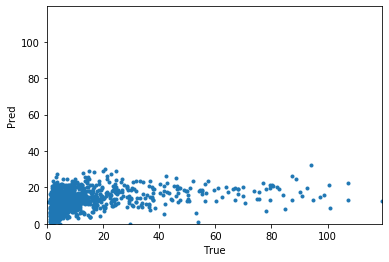

In [7]:
X, Y = preprocessing.standardize(ERSP, SLs)

# X, select_indices = preprocessing.select_correlated_ERSP(X, Y, threshold_corr=0.75)
X = X.reshape((X.shape[0],-1))

X = preprocessing.PCA_corr(X, Y, num_features=5)
rgr = LinearRegression()
rgr.fit(X, Y)

pred_Y = rgr.predict(X)

plot_scatter(Y, pred_Y)

# Regression for each subject

In [6]:
# Get list of data names
df_names = pd.read_csv('./Data_Matlab/data_list.csv')
data_names = [x[0:6] for x in df_names.values.flatten()]
data_names = [data_names[i] for i in range(11)]

for i_data, data_name in enumerate(data_names):
    
    X, Y_class, Y_reg, channels = dl.read_data([1,2,3], [i_data], 'class')

    # Adopt STFT and save file
    freq, t, Zxx  = bandpower.STFT(X, Y_reg, channels, 2, 30)

    # Read pickle file
    with open('./ERSP_from_raw.data', 'rb') as fp:
        dict_ERSP = pickle.load(fp)

    ERSP, SLs, freq, t = dict_ERSP['ERSP'], dict_ERSP['SLs'], dict_ERSP['freq'], dict_ERSP['t']
    print('Shape of ERSP: ', ERSP.shape)
    print('Shape of SLs: ', SLs.shape)
    print('Shape of freq: ', freq.shape)
    print('Shape of t: ', t.shape)

    ERSP, SLs = preprocessing.remove_trials(ERSP, SLs, 40)
    mode_cv = 'LOO'
    if mode_cv == 'KFold':
        num_fold = 10
        kf = KFold(n_splits=num_fold, shuffle=True)
    else:
        num_fold = ERSP.shape[0]
        kf = LeaveOneOut()
        pred_Y = np.zeros(num_fold)

    train_std = np.zeros(num_fold)
    test_std = np.zeros(num_fold)
    train_r2 = np.zeros(num_fold)
    test_r2 = np.zeros(num_fold)
    train_base = np.zeros(num_fold)
    test_base = np.zeros(num_fold)
    train_base_r2 = np.zeros(num_fold)
    test_base_r2 = np.zeros(num_fold)

    method = 3
    select = []

    for i, (train_index, test_index) in enumerate(kf.split(ERSP)):
        print('---Iteration %d---\n'%(i))
        #print(test_index)

        # Standardize data
        X_all, Y = preprocessing.standardize(ERSP, SLs, train_indices=train_index)

        '''
        # Select correlated ERSP
        X_all, select_indices = preprocessing.select_correlated_ERSP(X_all, Y, threshold_corr=0.75, train_indices=train_index)
        select.append(select_indices)
        '''
        # Flatten X_all
        X_all = X_all.reshape((X_all.shape[0],-1))

        #X_all = preprocessing.bandpower(X_all, freqs, 5, 15)

        # Split data
        X_train, X_test = X_all[train_index, :], X_all[test_index, :]
        Y_train, Y_test = Y[train_index], Y[test_index]

        if method == 1:
            pca = PCA(n_components=0.9)
            pca.fit(X_train)
            X_train = pca.transform(X_train)
            X_test = pca.transform(X_test)
        elif method == 2:
            # PCA
            X_train, X_test = preprocessing.PCA_corr(X_train, Y_train, X_test=X_test, num_features=10)

        # 1. Regression directly
        #rgr = svm.SVR()
        #rgr = Ridge(alpha=1)
        rgr = LinearRegression()
        results, train_std[i], test_std[i], train_r2[i], test_r2[i], pred_train1, pred_test1 = regression(\
            X_train, Y_train, X_test, Y_test, rgr)
        print('Method 1: %f | %f\n'%(train_std[i], test_std[i]))
        if mode_cv == 'LOO':
            pred_Y[i] = pred_test1

        train_baseline = np.array([np.mean(Y_train)]*Y_train.shape[0])
        test_baseline = np.array([np.mean(Y_train)]*Y_test.shape[0])
        print('Baseline: %f | %f\n'%(standard_error(train_baseline, Y_train), standard_error(test_baseline, Y_test)))
        train_base[i] = standard_error(train_baseline, Y_train)
        test_base[i] = standard_error(test_baseline, Y_test)
        train_base_r2[i] = r2_score(Y_train, train_baseline)
        test_base_r2[i] = r2_score(Y_test, test_baseline)

    if mode_cv == 'KFold':
        plot_scatter(Y_test, pred_test1, data_name)
    else:
        plot_scatter(SLs, pred_Y, data_name)
        
    plt.close()
    

After removing outliers, X shape:  (63, 12, 512)
Mean of all trials: 18.354229
--- Arrange all the channels as the same order ---

--- STFT ---

Transform to dB
2 - 30 Hz: 57 steps
Shape of ERSP:  (63, 12, 57, 172)
Shape of SLs:  (63,)
Shape of freq:  (57,)
Shape of t:  (172,)
> Remove 7 trials
---Iteration 0---

Base threshold: 4.2227
Method 1: 0.000000 | 5.817714

Baseline: 10.030023 | 5.533949

---Iteration 1---

Base threshold: 4.2227
Method 1: 0.000000 | 3.548331

Baseline: 10.024474 | 6.070881

---Iteration 2---

Base threshold: 4.2227
Method 1: 0.000000 | 1.588916

Baseline: 10.003241 | 7.789062

---Iteration 3---

Base threshold: 4.2227
Method 1: 0.000000 | 9.758076

Baseline: 9.975526 | 9.574858

---Iteration 4---

Base threshold: 4.2227
Method 1: 0.000000 | 6.624583

Baseline: 9.996517 | 8.258381

---Iteration 5---

Base threshold: 4.2227
Method 1: 0.000000 | 13.427449

Baseline: 10.013979 | 6.973722

---Iteration 6---

Base threshold: 4.2227
Method 1: 0.000000 | 5.769610

Ba

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Method 1: 0.000000 | 23.950622

Baseline: 9.628434 | 21.742188

---Iteration 11---

Base threshold: 4.2227
Method 1: 0.000000 | 17.666159

Baseline: 9.980029 | 9.308381

---Iteration 12---

Base threshold: 4.2227
Method 1: 0.000000 | 6.674049

Baseline: 9.997439 | 8.195597

---Iteration 13---

Base threshold: 4.2227
Method 1: 0.000000 | 14.854630

Baseline: 9.966348 | 10.095881

---Iteration 14---

Base threshold: 4.2227
Method 1: 0.000000 | 0.491504

Baseline: 10.022199 | 6.277699

---Iteration 15---

Base threshold: 4.2227
Method 1: 0.000000 | 8.179759

Baseline: 9.993126 | 8.485085

---Iteration 16---

Base threshold: 4.2227
Method 1: 0.000000 | 6.162140

Baseline: 9.996693 | 8.246449

---Iteration 17---

Base threshold: 4.2227
Method 1: 0.000000 | 4.529884

Baseline: 10.048664 | 3.108665

---Iteration 18---

Base threshold: 4.2227
Method 1: 0.000000 | 10.445868

Baseline: 9.971648 | 9.798438

---Iteration 19---

Base threshold: 4.2227
Method 1: 0.000000 | 11.795844

Baseline: 9.878

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 4.2227
Method 1: 0.000000 | 5.240053

Baseline: 9.984016 | 9.065767

---Iteration 24---

Base threshold: 4.2227
Method 1: 0.000000 | 5.067649

Baseline: 9.993246 | 8.477131

---Iteration 25---

Base threshold: 4.2227
Method 1: 0.000000 | 16.586662

Baseline: 9.821793 | 16.189915

---Iteration 26---

Base threshold: 4.2227
Method 1: 0.000000 | 9.391377

Baseline: 9.957129 | 10.593040

---Iteration 27---

Base threshold: 4.2227
Method 1: 0.000000 | 11.718314

Baseline: 10.036413 | 4.841903

---Iteration 28---

Base threshold: 4.2227
Method 1: 0.000000 | 3.160303

Baseline: 10.027375 | 5.796449

---Iteration 29---

Base threshold: 4.2227
Method 1: 0.000000 | 15.680765

Baseline: 9.726128 | 19.152983

---Iteration 30---

Base threshold: 4.2227
Method 1: 0.000000 | 11.357358

Baseline: 9.985492 | 8.974290

---Iteration 31---

Base threshold: 4.2227
Method 1: 0.000000 | 8.736168

Baseline: 10.003628 | 7.761222

---Iteration 32---

Base threshold: 4.2227
Method 1: 0.000000 | 3

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Method 1: 0.000000 | 1.742349

Baseline: 10.046578 | 3.465767

---Iteration 40---

Base threshold: 4.2227
Method 1: 0.000000 | 18.419750

Baseline: 9.904672 | 13.059801

---Iteration 41---

Base threshold: 4.2227
Method 1: 0.000000 | 2.375451

Baseline: 9.998898 | 8.095313

---Iteration 42---

Base threshold: 4.2227
Method 1: 0.000000 | 2.045026

Baseline: 10.054597 | 1.727699

---Iteration 43---

Base threshold: 4.2227
Method 1: 0.000000 | 23.642959

Baseline: 9.696363 | 19.980256

---Iteration 44---

Base threshold: 4.2227
Method 1: 0.000000 | 10.599319

Baseline: 9.988772 | 8.767472

---Iteration 45---

Base threshold: 4.2227
Method 1: 0.000000 | 12.608221

Baseline: 9.958259 | 10.533381

---Iteration 46---

Base threshold: 4.2227
Method 1: 0.000000 | 8.181027

Baseline: 10.047009 | 3.395028

---Iteration 47---

Base threshold: 4.2227
Method 1: 0.000000 | 14.474472

Baseline: 9.885752 | 13.839347

---Iteration 48---

Base threshold: 4.2227
Method 1: 0.000000 | 7.641716

Baseline: 10

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

After removing outliers, X shape:  (75, 12, 512)
Mean of all trials: 17.091458
--- Arrange all the channels as the same order ---

--- STFT ---

Transform to dB
2 - 30 Hz: 57 steps
Shape of ERSP:  (75, 12, 57, 172)
Shape of SLs:  (75,)
Shape of freq:  (57,)
Shape of t:  (172,)
> Remove 10 trials
---Iteration 0---

Base threshold: 3.2930
Method 1: 0.000000 | 2.416682

Baseline: 7.857481 | 2.482971

---Iteration 1---

Base threshold: 3.2930
Method 1: 0.000000 | 14.785932

Baseline: 7.813182 | 7.161499

---Iteration 2---

Base threshold: 3.2930
Method 1: 0.000000 | 4.581056

Baseline: 7.838321 | 5.070740

---Iteration 3---

Base threshold: 3.2930
Method 1: 0.000000 | 8.384007

Baseline: 7.807372 | 7.562195

---Iteration 4---

Base threshold: 3.2930
Method 1: 0.000000 | 19.479598

Baseline: 7.685725 | 13.404907

---Iteration 5---

Base threshold: 3.2930
Method 1: 0.000000 | 6.432567

Baseline: 7.805103 | 7.712952

---Iteration 6---

Base threshold: 3.2930
Method 1: 0.000000 | 2.955589

Bas

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 3.2930
Method 1: 0.000000 | 16.215794

Baseline: 7.648204 | 14.733948

---Iteration 19---

Base threshold: 3.2930
Method 1: 0.000000 | 5.125529

Baseline: 7.817236 | 6.867920

---Iteration 20---

Base threshold: 3.2930
Method 1: 0.000000 | 9.424480

Baseline: 7.804680 | 7.740723

---Iteration 21---

Base threshold: 3.2930
Method 1: 0.000000 | 0.982744

Baseline: 7.863483 | 0.179077

---Iteration 22---

Base threshold: 3.2930
Method 1: 0.000000 | 9.997512

Baseline: 7.767942 | 9.854187

---Iteration 23---

Base threshold: 3.2930
Method 1: 0.000000 | 5.040534

Baseline: 7.832576 | 5.618225

---Iteration 24---

Base threshold: 3.2930
Method 1: 0.000000 | 6.818316

Baseline: 7.813907 | 7.109924

---Iteration 25---

Base threshold: 3.2930
Method 1: 0.000000 | 0.414354

Baseline: 7.861784 | 1.329590

---Iteration 26---

Base threshold: 3.2930
Method 1: 0.000000 | 5.140552

Baseline: 7.863258 | 0.511230

---Iteration 27---

Base threshold: 3.2930
Method 1: 0.000000 | 5.051050


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 3.2930
Method 1: 0.000000 | 0.428019

Baseline: 7.857359 | 2.507874

---Iteration 39---

Base threshold: 3.2930
Method 1: 0.000000 | 6.106692

Baseline: 7.804982 | 7.720886

---Iteration 40---

Base threshold: 3.2930
Method 1: 0.000000 | 6.087807

Baseline: 7.832838 | 5.594421

---Iteration 41---

Base threshold: 3.2930
Method 1: 0.000000 | 16.476068

Baseline: 7.643949 | 14.876770

---Iteration 42---

Base threshold: 3.2930
Method 1: 0.000000 | 1.822606

Baseline: 7.853805 | 3.149475

---Iteration 43---

Base threshold: 3.2930
Method 1: 0.000000 | 6.678679

Baseline: 7.836594 | 5.241333

---Iteration 44---

Base threshold: 3.2930
Method 1: 0.000000 | 1.569918

Baseline: 7.850411 | 3.658386

---Iteration 45---

Base threshold: 3.2930
Method 1: 0.000000 | 0.851154

Baseline: 7.862537 | 0.999207

---Iteration 46---

Base threshold: 3.2930
Method 1: 0.000000 | 0.681405

Baseline: 7.851387 | 3.519531

---Iteration 47---

Base threshold: 3.2930
Method 1: 0.000000 | 0.329418


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 3.2930
Method 1: 0.000000 | 6.166690

Baseline: 7.846719 | 4.141296

---Iteration 59---

Base threshold: 3.2930
Method 1: 0.000000 | 4.308089

Baseline: 7.823559 | 6.382812

---Iteration 60---

Base threshold: 3.2930
Method 1: 0.000000 | 11.220187

Baseline: 7.814200 | 7.088989

---Iteration 61---

Base threshold: 3.2930
Method 1: 0.000000 | 0.634269

Baseline: 7.854448 | 3.043457

---Iteration 62---

Base threshold: 3.2930
Method 1: 0.000000 | 12.454996

Baseline: 7.558592 | 17.483276

---Iteration 63---

Base threshold: 3.2930
Method 1: 0.000000 | 6.766475

Baseline: 7.817878 | 6.820312

---Iteration 64---

Base threshold: 3.2930
Method 1: 0.000000 | 6.871180

Baseline: 7.802928 | 7.854675



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

After removing outliers, X shape:  (174, 12, 512)
Mean of all trials: 4.753053
--- Arrange all the channels as the same order ---

--- STFT ---

Transform to dB
2 - 30 Hz: 57 steps
Shape of ERSP:  (174, 12, 57, 172)
Shape of SLs:  (174,)
Shape of freq:  (57,)
Shape of t:  (172,)
> Remove 1 trials
---Iteration 0---

Base threshold: 1.5273
Method 1: 0.000000 | 8.061843

Baseline: 5.255868 | 1.218387

---Iteration 1---

Base threshold: 1.5273
Method 1: 0.000000 | 0.564063

Baseline: 5.253346 | 2.463867

---Iteration 2---

Base threshold: 1.5273
Method 1: 0.000000 | 3.230033

Baseline: 5.252906 | 2.621026

---Iteration 3---

Base threshold: 1.5273
Method 1: 0.000000 | 1.699812

Baseline: 5.252559 | 2.738894

---Iteration 4---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.5273
Method 1: 0.000000 | 5.426505

Baseline: 5.256158 | 0.978720

---Iteration 5---

Base threshold: 1.5273
Method 1: 0.000000 | 4.061997

Baseline: 5.253607 | 2.365643

---Iteration 6---

Base threshold: 1.5273
Method 1: 0.000000 | 1.566312

Baseline: 5.251740 | 2.998206

---Iteration 7---

Base threshold: 1.5273
Method 1: 0.000000 | 3.307083

Baseline: 5.255894 | 1.198742

---Iteration 8---

Base threshold: 1.5273
Method 1: 0.000000 | 1.398405

Baseline: 5.251727 | 3.002135

---Iteration 9---

Base threshold: 1.5273
Method 1: 0.000000 | 2.165142

Baseline: 5.256079 | 1.049441

---Iteration 10---

Base threshold: 1.5273
Method 1: 0.000000 | 3.346962

Baseline: 5.254467 | 2.008108

---Iteration 11---

Base threshold: 1.5273
Method 1: 0.000000 | 0.712745

Baseline: 5.254785 | 1.858807

---Iteration 12---

Base threshold: 1.5273


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Method 1: 0.000000 | 1.470668

Baseline: 5.256684 | 0.020054

---Iteration 13---

Base threshold: 1.5273
Method 1: 0.000000 | 3.413776

Baseline: 5.256038 | 1.084802

---Iteration 14---

Base threshold: 1.5273
Method 1: 0.000000 | 6.130164

Baseline: 5.252451 | 2.774255

---Iteration 15---

Base threshold: 1.5273
Method 1: 0.000000 | 8.198315

Baseline: 5.252475 | 2.766397

---Iteration 16---

Base threshold: 1.5273
Method 1: 0.000000 | 3.974582

Baseline: 5.251437 | 3.088572

---Iteration 17---

Base threshold: 1.5273
Method 1: 0.000000 | 7.367395

Baseline: 5.251662 | 3.021780

---Iteration 18---

Base threshold: 1.5273
Method 1: 0.000000 | 6.395501

Baseline: 5.250776 | 3.277162

---Iteration 19---

Base threshold: 1.5273
Method 1: 0.000000 | 2.443483

Baseline: 5.253074 | 2.562091

---Iteration 20---

Base threshold: 1.5273
Method 1: 0.000000 | 6.838140

Baseline: 5.254561 | 1.964889

---Iteration 21---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.5273
Method 1: 0.000000 | 1.582660

Baseline: 5.253441 | 2.428507

---Iteration 22---

Base threshold: 1.5273
Method 1: 0.000000 | 2.431889

Baseline: 5.254965 | 1.768441

---Iteration 23---

Base threshold: 1.5273
Method 1: 0.000000 | 0.601089

Baseline: 5.256345 | 0.786201

---Iteration 24---

Base threshold: 1.5273
Method 1: 0.000000 | 0.710193

Baseline: 5.250329 | 3.398960

---Iteration 25---

Base threshold: 1.5273
Method 1: 0.000000 | 0.026903

Baseline: 5.251740 | 2.998206

---Iteration 26---

Base threshold: 1.5273
Method 1: 0.000000 | 5.727199

Baseline: 5.251869 | 2.958916

---Iteration 27---

Base threshold: 1.5273
Method 1: 0.000000 | 5.042311

Baseline: 5.250166 | 3.442178

---Iteration 28---

Base threshold: 1.5273
Method 1: 0.000000 | 1.485192

Baseline: 5.250677 | 3.304665

---Iteration 29---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.5273
Method 1: 0.000000 | 2.225183

Baseline: 5.250270 | 3.414676

---Iteration 30---

Base threshold: 1.5273
Method 1: 0.000000 | 1.604871

Baseline: 5.252427 | 2.782113

---Iteration 31---

Base threshold: 1.5273
Method 1: 0.000000 | 0.284051

Baseline: 5.255782 | 1.281250

---Iteration 32---

Base threshold: 1.5273
Method 1: 0.000000 | 5.031213

Baseline: 5.251167 | 3.167151

---Iteration 33---

Base threshold: 1.5273
Method 1: 0.000000 | 6.277328

Baseline: 5.254317 | 2.074900

---Iteration 34---

Base threshold: 1.5273
Method 1: 0.000000 | 0.131960

Baseline: 5.250945 | 3.230015

---Iteration 35---

Base threshold: 1.5273
Method 1: 0.000000 | 0.215933

Baseline: 5.253140 | 2.538517

---Iteration 36---

Base threshold: 1.5273
Method 1: 0.000000 | 0.175273

Baseline: 5.253357 | 2.459938

---Iteration 37---

Base threshold: 1.5273
Method 1: 0.000000 | 3.401094

Baseline: 5.246219 | 4.360738

---Iteration 38---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.5273
Method 1: 0.000000 | 1.017082

Baseline: 5.254919 | 1.792015

---Iteration 39---

Base threshold: 1.5273
Method 1: 0.000000 | 1.615518

Baseline: 5.251651 | 3.024891

---Iteration 40---

Base threshold: 1.5273
Method 1: 0.000000 | 2.894195

Baseline: 5.254680 | 1.909066

---Iteration 41---

Base threshold: 1.5273
Method 1: 0.000000 | 5.467568

Baseline: 5.251856 | 2.962845

---Iteration 42---

Base threshold: 1.5273
Method 1: 0.000000 | 0.100799

Baseline: 5.255172 | 1.658430

---Iteration 43---

Base threshold: 1.5273
Method 1: 0.000000 | 0.627315

Baseline: 5.252711 | 2.687818

---Iteration 44---

Base threshold: 1.5273
Method 1: 0.000000 | 8.838023

Baseline: 5.240428 | 5.433344

---Iteration 45---

Base threshold: 1.5273
Method 1: 0.000000 | 0.191303

Baseline: 5.255614 | 1.395190

---Iteration 46---

Base threshold: 1.5273
Method 1: 0.000000 | 1.925465

Baseline: 5.256159 | 0.977902

---Iteration 47---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.5273
Method 1: 0.000000 | 4.577144

Baseline: 5.236283 | 6.085551

---Iteration 48---

Base threshold: 1.5273
Method 1: 0.000000 | 3.502589

Baseline: 5.254317 | 2.074900

---Iteration 49---

Base threshold: 1.5273
Method 1: 0.000000 | 1.303952

Baseline: 5.250388 | 3.383244

---Iteration 50---

Base threshold: 1.5273
Method 1: 0.000000 | 3.469137

Baseline: 5.253140 | 2.538517

---Iteration 51---

Base threshold: 1.5273
Method 1: 0.000000 | 14.456725

Baseline: 5.179483 | 11.806118

---Iteration 52---

Base threshold: 1.5273
Method 1: 0.000000 | 6.485901

Baseline: 5.251043 | 3.202512

---Iteration 53---

Base threshold: 1.5273
Method 1: 0.000000 | 2.259207

Baseline: 5.255373 | 1.544490

---Iteration 54---

Base threshold: 1.5273
Method 1: 0.000000 | 3.692923

Baseline: 5.256132 | 1.002294

---Iteration 55---

Base threshold: 1.5273
Method 1: 0.000000 | 3.746224

Baseline: 5.256642 | 0.279365

---Iteration 56---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.5273
Method 1: 0.000000 | 7.006810

Baseline: 5.254744 | 1.878452

---Iteration 57---

Base threshold: 1.5273
Method 1: 0.000000 | 2.455686

Baseline: 5.254995 | 1.752725

---Iteration 58---

Base threshold: 1.5273
Method 1: 0.000000 | 2.525794

Baseline: 5.256043 | 1.080055

---Iteration 59---

Base threshold: 1.5273
Method 1: 0.000000 | 2.744756

Baseline: 5.256642 | 0.279365

---Iteration 60---

Base threshold: 1.5273
Method 1: 0.000000 | 9.000664

Baseline: 5.227020 | 7.334961

---Iteration 61---

Base threshold: 1.5273
Method 1: 0.000000 | 6.599373

Baseline: 5.256137 | 0.998365

---Iteration 62---

Base threshold: 1.5273
Method 1: 0.000000 | 3.116208

Baseline: 5.254555 | 1.968001

---Iteration 63---

Base threshold: 1.5273
Method 1: 0.000000 | 5.344168

Baseline: 5.251846 | 2.965957

---Iteration 64---

Base threshold: 1.5273
Method 1: 0.000000 | 4.022574

Baseline: 5.254664 | 1.916924

---Iteration 65---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.5273
Method 1: 0.000000 | 3.347586

Baseline: 5.252549 | 2.742006

---Iteration 66---

Base threshold: 1.5273
Method 1: 0.000000 | 2.800815

Baseline: 5.255980 | 1.131949

---Iteration 67---

Base threshold: 1.5273
Method 1: 0.000000 | 1.420289

Baseline: 5.256539 | 0.514285

---Iteration 68---

Base threshold: 1.5273
Method 1: 0.000000 | 3.869648

Baseline: 5.252688 | 2.695676

---Iteration 69---

Base threshold: 1.5273
Method 1: 0.000000 | 2.728151

Baseline: 5.256231 | 0.907999

---Iteration 70---

Base threshold: 1.5273
Method 1: 0.000000 | 1.227973

Baseline: 5.250847 | 3.257517

---Iteration 71---

Base threshold: 1.5273
Method 1: 0.000000 | 0.302618

Baseline: 5.251167 | 3.167151

---Iteration 72---

Base threshold: 1.5273
Method 1: 0.000000 | 2.098976

Baseline: 5.255915 | 1.183026

---Iteration 73---

Base threshold: 1.5273
Method 1: 0.000000 | 0.282174

Baseline: 5.250519 | 3.347883

---Iteration 74---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.5273
Method 1: 0.000000 | 1.498941

Baseline: 5.254919 | 1.792015

---Iteration 75---

Base threshold: 1.5273
Method 1: 0.000000 | 0.270351

Baseline: 5.255559 | 1.430551

---Iteration 76---

Base threshold: 1.5273
Method 1: 0.000000 | 6.487537

Baseline: 5.253889 | 2.254815

---Iteration 77---

Base threshold: 1.5273
Method 1: 0.000000 | 3.891493

Baseline: 5.252711 | 2.687818

---Iteration 78---

Base threshold: 1.5273
Method 1: 0.000000 | 2.088449

Baseline: 5.251424 | 3.092501

---Iteration 79---

Base threshold: 1.5273
Method 1: 0.000000 | 7.593988

Baseline: 5.220407 | 8.108966

---Iteration 80---

Base threshold: 1.5273
Method 1: 0.000000 | 5.586146

Baseline: 5.251897 | 2.950241

---Iteration 81---

Base threshold: 1.5273
Method 1: 0.000000 | 4.399573

Baseline: 5.256532 | 0.526890

---Iteration 82---

Base threshold: 1.5273
Method 1: 0.000000 | 3.598131

Baseline: 5.253485 | 2.411973



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

---Iteration 83---

Base threshold: 1.5273
Method 1: 0.000000 | 5.252109

Baseline: 5.256409 | 0.707622

---Iteration 84---

Base threshold: 1.5273
Method 1: 0.000000 | 5.155011

Baseline: 5.253409 | 2.440293

---Iteration 85---

Base threshold: 1.5273
Method 1: 0.000000 | 7.310129

Baseline: 5.251544 | 3.057140

---Iteration 86---

Base threshold: 1.5273
Method 1: 0.000000 | 1.360501

Baseline: 5.250945 | 3.230015

---Iteration 87---

Base threshold: 1.5273
Method 1: 0.000000 | 5.321183

Baseline: 5.251817 | 2.974632

---Iteration 88---

Base threshold: 1.5273
Method 1: 0.000000 | 2.413903

Baseline: 5.251208 | 3.155364

---Iteration 89---

Base threshold: 1.5273
Method 1: 0.000000 | 0.912092

Baseline: 5.252439 | 2.778184

---Iteration 90---

Base threshold: 1.5273
Method 1: 0.000000 | 2.889550

Baseline: 5.254670 | 1.913813

---Iteration 91---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.5273
Method 1: 0.000000 | 1.497099

Baseline: 5.256443 | 0.663586

---Iteration 92---

Base threshold: 1.5273
Method 1: 0.000000 | 0.997944

Baseline: 5.256129 | 1.005405

---Iteration 93---

Base threshold: 1.5273
Method 1: 0.000000 | 3.161614

Baseline: 5.254484 | 2.000250

---Iteration 94---

Base threshold: 1.5273
Method 1: 0.000000 | 1.115563

Baseline: 5.250240 | 3.422534

---Iteration 95---

Base threshold: 1.5273
Method 1: 0.000000 | 3.431739

Baseline: 5.255151 | 1.670217

---Iteration 96---

Base threshold: 1.5273
Method 1: 0.000000 | 2.839156

Baseline: 5.255680 | 1.351971

---Iteration 97---

Base threshold: 1.5273
Method 1: 0.000000 | 1.346546

Baseline: 5.256645 | 0.266761

---Iteration 98---

Base threshold: 1.5273
Method 1: 0.000000 | 2.170372

Baseline: 5.253007 | 2.585665

---Iteration 99---

Base threshold: 1.5273


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Method 1: 0.000000 | 1.136595

Baseline: 5.253041 | 2.573878

---Iteration 100---

Base threshold: 1.5273
Method 1: 0.000000 | 2.815097

Baseline: 5.255509 | 1.461982

---Iteration 101---

Base threshold: 1.5273
Method 1: 0.000000 | 3.383352

Baseline: 5.251894 | 2.951058

---Iteration 102---

Base threshold: 1.5273
Method 1: 0.000000 | 5.954290

Baseline: 5.250344 | 3.395031

---Iteration 103---

Base threshold: 1.5273
Method 1: 0.000000 | 4.117866

Baseline: 5.256680 | 0.094704

---Iteration 104---

Base threshold: 1.5273
Method 1: 0.000000 | 0.844763

Baseline: 5.246796 | 4.238940

---Iteration 105---

Base threshold: 1.5273
Method 1: 0.000000 | 0.301751

Baseline: 5.251276 | 3.135719

---Iteration 106---

Base threshold: 1.5273
Method 1: 0.000000 | 4.523953

Baseline: 5.254088 | 2.173124

---Iteration 107---

Base threshold: 1.5273
Method 1: 0.000000 | 0.076792

Baseline: 5.256621 | 0.341411

---Iteration 108---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.5273
Method 1: 0.000000 | 0.793037

Baseline: 5.256684 | 0.019236

---Iteration 109---

Base threshold: 1.5273
Method 1: 0.000000 | 1.554482

Baseline: 5.249911 | 3.508971

---Iteration 110---

Base threshold: 1.5273
Method 1: 0.000000 | 5.845548

Baseline: 5.205369 | 9.637332

---Iteration 111---

Base threshold: 1.5273
Method 1: 0.000000 | 1.392077

Baseline: 5.254434 | 2.023006

---Iteration 112---

Base threshold: 1.5273
Method 1: 0.000000 | 0.621527

Baseline: 5.252111 | 2.883448

---Iteration 113---

Base threshold: 1.5273
Method 1: 0.000000 | 2.979569

Baseline: 5.254441 | 2.019895

---Iteration 114---

Base threshold: 1.5273
Method 1: 0.000000 | 2.557827

Baseline: 5.253617 | 2.361714

---Iteration 115---

Base threshold: 1.5273
Method 1: 0.000000 | 2.612592

Baseline: 5.256506 | 0.570108

---Iteration 116---

Base threshold: 1.5273
Method 1: 0.000000 | 2.117336

Baseline: 5.256328 | 0.805846

---Iteration 117---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.5273
Method 1: 0.000000 | 1.190740

Baseline: 5.255836 | 1.241960

---Iteration 118---

Base threshold: 1.5273
Method 1: 0.000000 | 1.571002

Baseline: 5.255925 | 1.175168

---Iteration 119---

Base threshold: 1.5273
Method 1: 0.000000 | 0.184390

Baseline: 5.256451 | 0.651799

---Iteration 120---

Base threshold: 1.5273
Method 1: 0.000000 | 3.990926

Baseline: 5.253847 | 2.271348

---Iteration 121---

Base threshold: 1.5273
Method 1: 0.000000 | 4.923834

Baseline: 5.255674 | 1.355900

---Iteration 122---

Base threshold: 1.5273
Method 1: 0.000000 | 4.345996

Baseline: 5.234117 | 6.399868

---Iteration 123---

Base threshold: 1.5273
Method 1: 0.000000 | 0.345448

Baseline: 5.250181 | 3.438249

---Iteration 124---

Base threshold: 1.5273
Method 1: 0.000000 | 1.103590

Baseline: 5.256489 | 0.596793

---Iteration 125---

Base threshold: 1.5273
Method 1: 0.000000 | 4.097115

Baseline: 5.251570 | 3.049282

---Iteration 126---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.5273
Method 1: 0.000000 | 2.218372

Baseline: 5.255271 | 1.603425

---Iteration 127---

Base threshold: 1.5273
Method 1: 0.000000 | 6.612925

Baseline: 5.188999 | 11.059616

---Iteration 128---

Base threshold: 1.5273
Method 1: 0.000000 | 0.910862

Baseline: 5.251623 | 3.033566

---Iteration 129---

Base threshold: 1.5273
Method 1: 0.000000 | 2.588193

Baseline: 5.253206 | 2.514944

---Iteration 130---

Base threshold: 1.5273
Method 1: 0.000000 | 9.094535

Baseline: 5.245450 | 4.517896

---Iteration 131---

Base threshold: 1.5273
Method 1: 0.000000 | 1.893885

Baseline: 5.198865 | 10.226676

---Iteration 132---

Base threshold: 1.5273
Method 1: 0.000000 | 3.508858

Baseline: 5.251869 | 2.958916

---Iteration 133---

Base threshold: 1.5273
Method 1: 0.000000 | 1.286765

Baseline: 5.252723 | 2.683889

---Iteration 134---

Base threshold: 1.5273
Method 1: 0.000000 | 1.257054

Baseline: 5.251180 | 3.163222

---Iteration 135---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.5273
Method 1: 0.000000 | 0.511030

Baseline: 5.256625 | 0.330441

---Iteration 136---

Base threshold: 1.5273
Method 1: 0.000000 | 2.432095

Baseline: 5.256358 | 0.770485

---Iteration 137---

Base threshold: 1.5273
Method 1: 0.000000 | 1.996555

Baseline: 5.254736 | 1.882381

---Iteration 138---

Base threshold: 1.5273
Method 1: 0.000000 | 2.900459

Baseline: 5.254768 | 1.866665

---Iteration 139---

Base threshold: 1.5273
Method 1: 0.000000 | 12.150951

Baseline: 5.236125 | 6.109125

---Iteration 140---

Base threshold: 1.5273
Method 1: 0.000000 | 1.804802

Baseline: 5.252906 | 2.621026

---Iteration 141---

Base threshold: 1.5273
Method 1: 0.000000 | 25.458804

Baseline: 4.751013 | 29.588595

---Iteration 142---

Base threshold: 1.5273
Method 1: 0.000000 | 1.042486

Baseline: 5.253504 | 2.404933

---Iteration 143---

Base threshold: 1.5273
Method 1: 0.000000 | 24.420990

Baseline: 4.831041 | 27.254792

---Iteration 144---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.5273
Method 1: 0.000000 | 2.897485

Baseline: 5.253993 | 2.212414

---Iteration 145---

Base threshold: 1.5273
Method 1: 0.000000 | 3.150722

Baseline: 5.253314 | 2.475654

---Iteration 146---

Base threshold: 1.5273
Method 1: 0.000000 | 20.021665

Baseline: 4.909436 | 24.712754

---Iteration 147---

Base threshold: 1.5273
Method 1: 0.000000 | 0.166701

Baseline: 5.251945 | 2.935342

---Iteration 148---

Base threshold: 1.5273
Method 1: 0.000000 | 5.072016

Baseline: 5.254317 | 2.074900

---Iteration 149---

Base threshold: 1.5273
Method 1: 0.000000 | 5.902764

Baseline: 5.252146 | 2.872479

---Iteration 150---

Base threshold: 1.5273
Method 1: 0.000000 | 26.598690

Baseline: 4.898830 | 25.074219

---Iteration 151---

Base threshold: 1.5273
Method 1: 0.000000 | 1.739336

Baseline: 5.252570 | 2.734965

---Iteration 152---

Base threshold: 1.5273
Method 1: 0.000000 | 5.637843

Baseline: 5.249773 | 3.544331

---Iteration 153---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.5273
Method 1: 0.000000 | 1.439836

Baseline: 5.251373 | 3.107399

---Iteration 154---

Base threshold: 1.5273
Method 1: 0.000000 | 2.078998

Baseline: 5.253099 | 2.553416

---Iteration 155---

Base threshold: 1.5273
Method 1: 0.000000 | 0.188837

Baseline: 5.253993 | 2.212414

---Iteration 156---

Base threshold: 1.5273
Method 1: 0.000000 | 2.558857

Baseline: 5.256419 | 0.695017

---Iteration 157---

Base threshold: 1.5273
Method 1: 0.000000 | 3.396641

Baseline: 5.251766 | 2.990348

---Iteration 158---

Base threshold: 1.5273
Method 1: 0.000000 | 7.261113

Baseline: 5.107340 | 16.363713

---Iteration 159---

Base threshold: 1.5273
Method 1: 0.000000 | 4.785608

Baseline: 5.250106 | 3.457894

---Iteration 160---

Base threshold: 1.5273
Method 1: 0.000000 | 1.036293

Baseline: 5.255986 | 1.127203

---Iteration 161---

Base threshold: 1.5273


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Method 1: 0.000000 | 5.767532

Baseline: 5.238465 | 5.751590

---Iteration 162---

Base threshold: 1.5273
Method 1: 0.000000 | 1.672693

Baseline: 5.253409 | 2.440293

---Iteration 163---

Base threshold: 1.5273
Method 1: 0.000000 | 2.002626

Baseline: 5.250723 | 3.292060

---Iteration 164---

Base threshold: 1.5273
Method 1: 0.000000 | 4.799197

Baseline: 5.226797 | 7.362464

---Iteration 165---

Base threshold: 1.5273
Method 1: 0.000000 | 2.737933

Baseline: 5.255626 | 1.387332

---Iteration 166---

Base threshold: 1.5273
Method 1: 0.000000 | 0.425753

Baseline: 5.254388 | 2.043468

---Iteration 167---

Base threshold: 1.5273
Method 1: 0.000000 | 4.297109

Baseline: 5.255656 | 1.367687

---Iteration 168---

Base threshold: 1.5273
Method 1: 0.000000 | 1.723137

Baseline: 5.256285 | 0.852993

---Iteration 169---

Base threshold: 1.5273
Method 1: 0.000000 | 1.225275

Baseline: 5.256321 | 0.813704

---Iteration 170---

Base threshold: 1.5273


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Method 1: 0.000000 | 2.322749

Baseline: 5.256623 | 0.333553

---Iteration 171---

Base threshold: 1.5273
Method 1: 0.000000 | 3.624426

Baseline: 5.252269 | 2.833189

---Iteration 172---

Base threshold: 1.5273
Method 1: 0.000000 | 0.540634

Baseline: 5.256685 | 0.000409

After removing outliers, X shape:  (140, 12, 512)
Mean of all trials: 8.468443
--- Arrange all the channels as the same order ---

--- STFT ---

Transform to dB
2 - 30 Hz: 57 steps
Shape of ERSP:  (140, 12, 57, 172)
Shape of SLs:  (140,)
Shape of freq:  (57,)
Shape of t:  (172,)
> Remove 6 trials
---Iteration 0---

Base threshold: 1.7820
Method 1: 0.000000 | 14.645323

Baseline: 6.819899 | 5.183183

---Iteration 1---

Base threshold: 1.7820
Method 1: 0.000000 | 6.753423

Baseline: 6.826736 | 3.789973

---Iteration 2---

Base threshold: 1.7820
Method 1: 0.000000 | 4.070917

Baseline: 6.833846 | 1.160979

---Iteration 3---

Base threshold: 1.7820
Method 1: 0.000000 | 2.827095

Baseline: 6.822435 | 4.714844

---Iteratio

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Method 1: 0.000000 | 1.406591

Baseline: 6.830366 | 2.778519

---Iteration 10---

Base threshold: 1.7820
Method 1: 0.000000 | 5.433682

Baseline: 6.834487 | 0.417205

---Iteration 11---

Base threshold: 1.7820
Method 1: 0.000000 | 12.224383

Baseline: 6.826439 | 3.860814

---Iteration 12---

Base threshold: 1.7820
Method 1: 0.000000 | 10.017165

Baseline: 6.829824 | 2.951686

---Iteration 13---

Base threshold: 1.7820
Method 1: 0.000000 | 11.226406

Baseline: 6.819720 | 5.214668

---Iteration 14---

Base threshold: 1.7820
Method 1: 0.000000 | 4.483842

Baseline: 6.828060 | 3.455445

---Iteration 15---

Base threshold: 1.7820
Method 1: 0.000000 | 11.600778

Baseline: 6.822374 | 4.726651

---Iteration 16---

Base threshold: 1.7820
Method 1: 0.000000 | 7.593343

Baseline: 6.825813 | 4.006432

---Iteration 17---

Base threshold: 1.7820
Method 1: 0.000000 | 7.988810

Baseline: 6.825950 | 3.974947

---Iteration 18---

Base threshold: 1.7820
Method 1: 0.000000 | 7.529805

Baseline: 6.833516 |

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.7820
Method 1: 0.000000 | 6.096995

Baseline: 6.831958 | 2.192170

---Iteration 22---

Base threshold: 1.7820
Method 1: 0.000000 | 10.420117

Baseline: 6.786634 | 9.354999

---Iteration 23---

Base threshold: 1.7820
Method 1: 0.000000 | 4.086537

Baseline: 6.826703 | 3.797844

---Iteration 24---

Base threshold: 1.7820
Method 1: 0.000000 | 32.504999

Baseline: 6.272275 | 31.425957

---Iteration 25---

Base threshold: 1.7820
Method 1: 0.000000 | 6.983051

Baseline: 6.829208 | 3.136719

---Iteration 26---

Base threshold: 1.7820
Method 1: 0.000000 | 2.250200

Baseline: 6.820605 | 5.057243

---Iteration 27---

Base threshold: 1.7820
Method 1: 0.000000 | 3.531641

Baseline: 6.825092 | 4.167793

---Iteration 28---

Base threshold: 1.7820
Method 1: 0.000000 | 1.343584

Baseline: 6.823253 | 4.553483

---Iteration 29---

Base threshold: 1.7820
Method 1: 0.000000 | 1.415617

Baseline: 6.829141 | 3.156338

---Iteration 30---

Base threshold: 1.7820
Method 1: 0.000000 | 6.331156

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Method 1: 0.000000 | 10.346065

Baseline: 6.833627 | 1.322339

---Iteration 33---

Base threshold: 1.7820
Method 1: 0.000000 | 1.599429

Baseline: 6.824042 | 4.392123

---Iteration 34---

Base threshold: 1.7820
Method 1: 0.000000 | 11.343927

Baseline: 6.823776 | 4.447222

---Iteration 35---

Base threshold: 1.7820
Method 1: 0.000000 | 7.872160

Baseline: 6.822877 | 4.628260

---Iteration 36---

Base threshold: 1.7820
Method 1: 0.000000 | 5.183658

Baseline: 6.822957 | 4.612518

---Iteration 37---

Base threshold: 1.7820
Method 1: 0.000000 | 15.919003

Baseline: 6.672197 | 17.143591

---Iteration 38---

Base threshold: 1.7820
Method 1: 0.000000 | 11.329264

Baseline: 6.711362 | 14.955387

---Iteration 39---

Base threshold: 1.7820
Method 1: 0.000000 | 11.556666

Baseline: 6.742541 | 12.940349

---Iteration 40---

Base threshold: 1.7820
Method 1: 0.000000 | 3.051358

Baseline: 6.832568 | 1.920553

---Iteration 41---

Base threshold: 1.7820
Method 1: 0.000000 | 7.015434

Baseline: 6.8265

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.7820
Method 1: 0.000000 | 3.320763

Baseline: 6.831986 | 2.180304

---Iteration 44---

Base threshold: 1.7820
Method 1: 0.000000 | 13.405963

Baseline: 6.792437 | 8.772527

---Iteration 45---

Base threshold: 1.7820
Method 1: 0.000000 | 0.352675

Baseline: 6.824361 | 4.325217

---Iteration 46---

Base threshold: 1.7820
Method 1: 0.000000 | 9.581658

Baseline: 6.834512 | 0.358112

---Iteration 47---

Base threshold: 1.7820
Method 1: 0.000000 | 0.017170

Baseline: 6.830437 | 2.754905

---Iteration 48---

Base threshold: 1.7820
Method 1: 0.000000 | 7.972020

Baseline: 6.824230 | 4.352767

---Iteration 49---

Base threshold: 1.7820
Method 1: 0.000000 | 3.358551

Baseline: 6.824118 | 4.376380

---Iteration 50---

Base threshold: 1.7820
Method 1: 0.000000 | 7.368462

Baseline: 6.821015 | 4.982466

---Iteration 51---

Base threshold: 1.7820
Method 1: 0.000000 | 4.685186

Baseline: 6.834078 | 0.960321

---Iteration 52---

Base threshold: 1.7820
Method 1: 0.000000 | 4.766862



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.7820
Method 1: 0.000000 | 0.999831

Baseline: 6.832823 | 1.794672

---Iteration 55---

Base threshold: 1.7820
Method 1: 0.000000 | 12.633756

Baseline: 6.800502 | 7.890948

---Iteration 56---

Base threshold: 1.7820
Method 1: 0.000000 | 3.725384

Baseline: 6.833694 | 1.275112

---Iteration 57---

Base threshold: 1.7820
Method 1: 0.000000 | 11.373924

Baseline: 6.823213 | 4.561413

---Iteration 58---

Base threshold: 1.7820
Method 1: 0.000000 | 3.517615

Baseline: 6.832161 | 2.105527

---Iteration 59---

Base threshold: 1.7820
Method 1: 0.000000 | 13.111444

Baseline: 6.823641 | 4.474830

---Iteration 60---

Base threshold: 1.7820
Method 1: 0.000000 | 1.615678

Baseline: 6.826422 | 3.864809

---Iteration 61---

Base threshold: 1.7820
Method 1: 0.000000 | 1.412229

Baseline: 6.823233 | 4.557419

---Iteration 62---

Base threshold: 1.7820
Method 1: 0.000000 | 1.570945

Baseline: 6.824565 | 4.281926

---Iteration 63---

Base threshold: 1.7820
Method 1: 0.000000 | 6.229319

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.7820
Method 1: 0.000000 | 6.499876

Baseline: 6.834518 | 0.342428

---Iteration 66---

Base threshold: 1.7820
Method 1: 0.000000 | 3.126230

Baseline: 6.829316 | 3.105234

---Iteration 67---

Base threshold: 1.7820
Method 1: 0.000000 | 9.675371

Baseline: 6.826053 | 3.951333

---Iteration 68---

Base threshold: 1.7820
Method 1: 0.000000 | 4.238505

Baseline: 6.826472 | 3.852943

---Iteration 69---

Base threshold: 1.7820
Method 1: 0.000000 | 9.540560

Baseline: 6.833236 | 1.570342

---Iteration 70---

Base threshold: 1.7820
Method 1: 0.000000 | 7.900514

Baseline: 6.824249 | 4.348831

---Iteration 71---

Base threshold: 1.7820
Method 1: 0.000000 | 16.369788

Baseline: 6.823603 | 4.482642

---Iteration 72---

Base threshold: 1.7820
Method 1: 0.000000 | 1.384676

Baseline: 6.834565 | 0.177074

---Iteration 73---

Base threshold: 1.7820
Method 1: 0.000000 | 2.510564

Baseline: 6.833836 | 1.168850

---Iteration 74---

Base threshold: 1.7820
Method 1: 0.000000 | 5.663799



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Method 1: 0.000000 | 5.934293

Baseline: 6.820342 | 5.104470

---Iteration 77---

Base threshold: 1.7820
Method 1: 0.000000 | 4.150863

Baseline: 6.821839 | 4.828977

---Iteration 78---

Base threshold: 1.7820
Method 1: 0.000000 | 0.504374

Baseline: 6.826736 | 3.789973

---Iteration 79---

Base threshold: 1.7820
Method 1: 0.000000 | 7.399469

Baseline: 6.826801 | 3.774230

---Iteration 80---

Base threshold: 1.7820
Method 1: 0.000000 | 1.363803

Baseline: 6.823757 | 4.451157

---Iteration 81---

Base threshold: 1.7820
Method 1: 0.000000 | 2.811483

Baseline: 6.829316 | 3.105175

---Iteration 82---

Base threshold: 1.7820
Method 1: 0.000000 | 9.292177

Baseline: 6.823814 | 4.439350

---Iteration 83---

Base threshold: 1.7820
Method 1: 0.000000 | 7.516194

Baseline: 6.833139 | 1.625441

---Iteration 84---

Base threshold: 1.7820
Method 1: 0.000000 | 29.752675

Baseline: 6.530030 | 23.354000

---Iteration 85---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.7820
Method 1: 0.000000 | 2.322920

Baseline: 6.821651 | 4.864397

---Iteration 86---

Base threshold: 1.7820
Method 1: 0.000000 | 6.798394

Baseline: 6.819130 | 5.317052

---Iteration 87---

Base threshold: 1.7820
Method 1: 0.000000 | 3.313234

Baseline: 6.807372 | 7.052661

---Iteration 88---

Base threshold: 1.7820
Method 1: 0.000000 | 4.752760

Baseline: 6.830366 | 2.778519

---Iteration 89---

Base threshold: 1.7820
Method 1: 0.000000 | 13.717677

Baseline: 6.821399 | 4.911625

---Iteration 90---

Base threshold: 1.7820
Method 1: 0.000000 | 7.976479

Baseline: 6.828782 | 3.258664

---Iteration 91---

Base threshold: 1.7820
Method 1: 0.000000 | 7.662371

Baseline: 6.821101 | 4.966723

---Iteration 92---

Base threshold: 1.7820
Method 1: 0.000000 | 16.781109

Baseline: 6.765498 | 11.220483

---Iteration 93---

Base threshold: 1.7820
Method 1: 0.000000 | 0.160196

Baseline: 6.832800 | 1.806420

---Iteration 94---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.7820
Method 1: 0.000000 | 3.670626

Baseline: 6.830062 | 2.876909

---Iteration 95---

Base threshold: 1.7820
Method 1: 0.000000 | 15.658940

Baseline: 6.635298 | 18.965784

---Iteration 96---

Base threshold: 1.7820
Method 1: 0.000000 | 6.633649

Baseline: 6.824136 | 4.372445

---Iteration 97---

Base threshold: 1.7820
Method 1: 0.000000 | 3.062201

Baseline: 6.834456 | 0.480116

---Iteration 98---

Base threshold: 1.7820
Method 1: 0.000000 | 5.620666

Baseline: 6.826256 | 3.904106

---Iteration 99---

Base threshold: 1.7820
Method 1: 0.000000 | 10.963672

Baseline: 6.788200 | 9.201510

---Iteration 100---

Base threshold: 1.7820
Method 1: 0.000000 | 1.666177

Baseline: 6.823194 | 4.565290

---Iteration 101---

Base threshold: 1.7820
Method 1: 0.000000 | 1.834948

Baseline: 6.824061 | 4.388187

---Iteration 102---

Base threshold: 1.7820
Method 1: 0.000000 | 5.015310

Baseline: 6.745892 | 12.704212

---Iteration 103---

Base threshold: 1.7820
Method 1: 0.000000 | 9.3

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Method 1: 0.000000 | 16.810606

Baseline: 6.605501 | 20.311766

---Iteration 105---

Base threshold: 1.7820
Method 1: 0.000000 | 11.307587

Baseline: 6.829382 | 3.085497

---Iteration 106---

Base threshold: 1.7820
Method 1: 0.000000 | 2.901471

Baseline: 6.831214 | 2.483347

---Iteration 107---

Base threshold: 1.7820
Method 1: 0.000000 | 5.821298

Baseline: 6.834371 | 0.621799

---Iteration 108---

Base threshold: 1.7820
Method 1: 0.000000 | 6.484095

Baseline: 6.829073 | 3.176016

---Iteration 109---

Base threshold: 1.7820
Method 1: 0.000000 | 2.653493

Baseline: 6.825778 | 4.014362

---Iteration 110---

Base threshold: 1.7820
Method 1: 0.000000 | 0.682120

Baseline: 6.801349 | 7.792558

---Iteration 111---

Base threshold: 1.7820
Method 1: 0.000000 | 0.257137

Baseline: 6.834346 | 0.657278

---Iteration 112---

Base threshold: 1.7820
Method 1: 0.000000 | 5.278630

Baseline: 6.827744 | 3.538093

---Iteration 113---

Base threshold: 1.7820
Method 1: 0.000000 | 0.554986

Baseline: 6.

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Method 1: 0.000000 | 8.370336

Baseline: 6.762295 | 11.476298

---Iteration 115---

Base threshold: 1.7820
Method 1: 0.000000 | 0.636429

Baseline: 6.834441 | 0.507666

---Iteration 116---

Base threshold: 1.7820
Method 1: 0.000000 | 5.365821

Baseline: 6.827264 | 3.660156

---Iteration 117---

Base threshold: 1.7820
Method 1: 0.000000 | 9.053215

Baseline: 6.832641 | 1.885191

---Iteration 118---

Base threshold: 1.7820
Method 1: 0.000000 | 1.336760

Baseline: 6.833125 | 1.633312

---Iteration 119---

Base threshold: 1.7820
Method 1: 0.000000 | 4.613168

Baseline: 6.804212 | 7.450159

---Iteration 120---

Base threshold: 1.7820
Method 1: 0.000000 | 3.893602

Baseline: 6.823947 | 4.411801

---Iteration 121---

Base threshold: 1.7820
Method 1: 0.000000 | 0.646341

Baseline: 6.826506 | 3.845072

---Iteration 122---

Base threshold: 1.7820
Method 1: 0.000000 | 2.212260

Baseline: 6.826289 | 3.896235

---Iteration 123---

Base threshold: 1.7820
Method 1: 0.000000 | 5.961934

Baseline: 6.83

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 1.7820
Method 1: 0.000000 | 2.911189

Baseline: 6.833302 | 1.530986

---Iteration 126---

Base threshold: 1.7820
Method 1: 0.000000 | 3.635780

Baseline: 6.831085 | 2.530574

---Iteration 127---

Base threshold: 1.7820
Method 1: 0.000000 | 4.308810

Baseline: 6.822394 | 4.722715

---Iteration 128---

Base threshold: 1.7820
Method 1: 0.000000 | 1.038146

Baseline: 6.826833 | 3.766359

---Iteration 129---

Base threshold: 1.7820
Method 1: 0.000000 | 8.002771

Baseline: 6.832753 | 1.830034

---Iteration 130---

Base threshold: 1.7820
Method 1: 0.000000 | 1.493729

Baseline: 6.829208 | 3.136660

---Iteration 131---

Base threshold: 1.7820
Method 1: 0.000000 | 26.291649

Baseline: 6.301841 | 30.623091

---Iteration 132---

Base threshold: 1.7820
Method 1: 0.000000 | 0.427301

Baseline: 6.834570 | 0.145589

---Iteration 133---

Base threshold: 1.7820
Method 1: 0.000000 | 3.772763

Baseline: 6.823545 | 4.494449



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

After removing outliers, X shape:  (49, 12, 512)
Mean of all trials: 27.973294
--- Arrange all the channels as the same order ---

--- STFT ---

Transform to dB
2 - 30 Hz: 57 steps
Shape of ERSP:  (49, 12, 57, 172)
Shape of SLs:  (49,)
Shape of freq:  (57,)
Shape of t:  (172,)
> Remove 11 trials
---Iteration 0---

Base threshold: 9.9430
Method 1: 0.000000 | 3.938189

Baseline: 7.755338 | 2.804160

---Iteration 1---

Base threshold: 9.9430
Method 1: 0.000000 | 8.348164

Baseline: 7.653707 | 8.208087

---Iteration 2---

Base threshold: 9.9430
Method 1: 0.000000 | 5.694910

Baseline: 7.753073 | 3.032834

---Iteration 3---

Base threshold: 9.9430
Method 1: 0.000000 | 2.231842

Baseline: 7.726027 | 5.010663

---Iteration 4---

Base threshold: 9.9430
Method 1: 0.000000 | 18.616369

Baseline: 7.217514 | 17.716322

---Iteration 5---

Base threshold: 9.9430
Method 1: 0.000000 | 2.407085

Baseline: 7.764710 | 1.528399

---Iteration 6---

Base threshold: 9.9430
Method 1: 0.000000 | 6.437374

Base

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Method 1: 0.000000 | 2.553225

Baseline: 7.753563 | 2.984903

---Iteration 29---

Base threshold: 9.9430
Method 1: 0.000000 | 0.363433

Baseline: 7.767522 | 0.822318

---Iteration 30---

Base threshold: 9.9430
Method 1: 0.000000 | 8.434315

Baseline: 7.714048 | 5.668813

---Iteration 31---

Base threshold: 9.9430
Method 1: 0.000000 | 17.757814

Baseline: 6.933583 | 21.599768

---Iteration 32---

Base threshold: 9.9430
Method 1: 0.000000 | 16.089311

Baseline: 7.528692 | 11.810916

---Iteration 33---

Base threshold: 9.9430
Method 1: 0.000000 | 0.372356

Baseline: 7.744442 | 3.779033

---Iteration 34---

Base threshold: 9.9430
Method 1: 0.000000 | 5.686223

Baseline: 7.705180 | 6.109903

---Iteration 35---

Base threshold: 9.9430
Method 1: 0.000000 | 10.903662

Baseline: 7.634615 | 8.858003

---Iteration 36---

Base threshold: 9.9430
Method 1: 0.000000 | 5.447828

Baseline: 7.627282 | 9.094911

---Iteration 37---

Base threshold: 9.9430
Method 1: 0.000000 | 0.330561

Baseline: 7.722673 

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

After removing outliers, X shape:  (100, 12, 512)
Mean of all trials: 15.045273
--- Arrange all the channels as the same order ---

--- STFT ---

Transform to dB
2 - 30 Hz: 57 steps
Shape of ERSP:  (100, 12, 57, 172)
Shape of SLs:  (100,)
Shape of freq:  (57,)
Shape of t:  (172,)
> Remove 9 trials
---Iteration 0---

Base threshold: 2.6367
Method 1: 0.000000 | 4.544519

Baseline: 8.894676 | 3.177517

---Iteration 1---

Base threshold: 2.6367
Method 1: 0.000000 | 12.392787

Baseline: 8.879348 | 5.906727

---Iteration 2---

Base threshold: 2.6367
Method 1: 0.000000 | 5.488441

Baseline: 8.900615 | 0.693186

---Iteration 3---

Base threshold: 2.6367
Method 1: 0.000000 | 8.778645

Baseline: 8.876854 | 6.238498

---Iteration 4---

Base threshold: 2.6367
Method 1: 0.000000 | 14.288149

Baseline: 8.880851 | 5.697396

---Iteration 5---

Base threshold: 2.6367
Method 1: 0.000000 | 5.640060

Baseline: 8.877671 | 6.131858

---Iteration 6---

Base threshold: 2.6367
Method 1: 0.000000 | 12.119700

B

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Method 1: 0.000000 | 9.811371

Baseline: 8.874480 | 6.538672

---Iteration 15---

Base threshold: 2.6367
Method 1: 0.000000 | 1.492537

Baseline: 8.895340 | 3.003733

---Iteration 16---

Base threshold: 2.6367
Method 1: 0.000000 | 2.263201

Baseline: 8.893577 | 3.446094

---Iteration 17---

Base threshold: 2.6367
Method 1: 0.000000 | 6.984922

Baseline: 8.873869 | 6.613715

---Iteration 18---

Base threshold: 2.6367
Method 1: 0.000000 | 1.017248

Baseline: 8.900911 | 0.017795

---Iteration 19---

Base threshold: 2.6367
Method 1: 0.000000 | 17.341107

Baseline: 8.881239 | 5.642101

---Iteration 20---

Base threshold: 2.6367
Method 1: 0.000000 | 9.529950

Baseline: 8.866974 | 7.407595

---Iteration 21---

Base threshold: 2.6367
Method 1: 0.000000 | 10.030796

Baseline: 8.896607 | 2.640365

---Iteration 22---

Base threshold: 2.6367
Method 1: 0.000000 | 7.007236

Baseline: 8.899249 | 1.641102

---Iteration 23---

Base threshold: 2.6367
Method 1: 0.000000 | 12.407431

Baseline: 8.872127 | 

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 2.6367
Method 1: 0.000000 | 7.109000

Baseline: 8.886200 | 4.879818

---Iteration 31---

Base threshold: 2.6367
Method 1: 0.000000 | 28.915747

Baseline: 8.562735 | 23.182465

---Iteration 32---

Base threshold: 2.6367
Method 1: 0.000000 | 7.092127

Baseline: 8.789186 | 13.411024

---Iteration 33---

Base threshold: 2.6367
Method 1: 0.000000 | 11.686316

Baseline: 8.871624 | 6.882292

---Iteration 34---

Base threshold: 2.6367
Method 1: 0.000000 | 7.725035

Baseline: 8.868727 | 7.214063

---Iteration 35---

Base threshold: 2.6367
Method 1: 0.000000 | 8.703305

Baseline: 8.890758 | 4.054340

---Iteration 36---

Base threshold: 2.6367
Method 1: 0.000000 | 0.839625

Baseline: 8.900727 | 0.547005

---Iteration 37---

Base threshold: 2.6367
Method 1: 0.000000 | 3.378796

Baseline: 8.900302 | 0.993316

---Iteration 38---

Base threshold: 2.6367
Method 1: 0.000000 | 6.403107

Baseline: 8.866901 | 7.415495

---Iteration 39---

Base threshold: 2.6367
Method 1: 0.000000 | 4.38072

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Method 1: 0.000000 | 0.932136

Baseline: 8.887798 | 4.607292

---Iteration 47---

Base threshold: 2.6367
Method 1: 0.000000 | 2.742618

Baseline: 8.877910 | 6.100260

---Iteration 48---

Base threshold: 2.6367
Method 1: 0.000000 | 2.325820

Baseline: 8.883745 | 5.270790

---Iteration 49---

Base threshold: 2.6367
Method 1: 0.000000 | 27.419745

Baseline: 8.523771 | 24.454253

---Iteration 50---

Base threshold: 2.6367
Method 1: 0.000000 | 24.597638

Baseline: 8.879550 | 5.879080

---Iteration 51---

Base threshold: 2.6367
Method 1: 0.000000 | 4.812537

Baseline: 8.897215 | 2.446832

---Iteration 52---

Base threshold: 2.6367
Method 1: 0.000000 | 1.350907

Baseline: 8.889620 | 4.275521

---Iteration 53---

Base threshold: 2.6367
Method 1: 0.000000 | 0.050557

Baseline: 8.867588 | 7.340451

---Iteration 54---

Base threshold: 2.6367
Method 1: 0.000000 | 1.803857

Baseline: 8.876333 | 6.305599

---Iteration 55---

Base threshold: 2.6367
Method 1: 0.000000 | 2.777021

Baseline: 8.875084 | 

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 2.6367
Method 1: 0.000000 | 12.115050

Baseline: 8.883539 | 5.302387

---Iteration 63---

Base threshold: 2.6367
Method 1: 0.000000 | 3.736941

Baseline: 8.897621 | 2.308550

---Iteration 64---

Base threshold: 2.6367
Method 1: 0.000000 | 0.675466

Baseline: 8.888044 | 4.563845

---Iteration 65---

Base threshold: 2.6367
Method 1: 0.000000 | 5.960910

Baseline: 8.899687 | 1.408073

---Iteration 66---

Base threshold: 2.6367
Method 1: 0.000000 | 21.198607

Baseline: 8.752569 | 15.437196

---Iteration 67---

Base threshold: 2.6367
Method 1: 0.000000 | 6.983687

Baseline: 8.880907 | 5.689497

---Iteration 68---

Base threshold: 2.6367
Method 1: 0.000000 | 4.963844

Baseline: 8.786922 | 13.545312

---Iteration 69---

Base threshold: 2.6367
Method 1: 0.000000 | 14.713323

Baseline: 8.866974 | 7.407595

---Iteration 70---

Base threshold: 2.6367
Method 1: 0.000000 | 11.519751

Baseline: 8.793708 | 13.138498

---Iteration 71---

Base threshold: 2.6367
Method 1: 0.000000 | 9.90

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Method 1: 0.000000 | 6.876561

Baseline: 8.870468 | 7.016580

---Iteration 78---

Base threshold: 2.6367
Method 1: 0.000000 | 0.787001

Baseline: 8.876117 | 6.333290

---Iteration 79---

Base threshold: 2.6367
Method 1: 0.000000 | 5.298205

Baseline: 8.889890 | 4.224175

---Iteration 80---

Base threshold: 2.6367
Method 1: 0.000000 | 1.614452

Baseline: 8.890877 | 4.030642

---Iteration 81---

Base threshold: 2.6367
Method 1: 0.000000 | 33.515208

Baseline: 8.423294 | 27.440191

---Iteration 82---

Base threshold: 2.6367
Method 1: 0.000000 | 21.451390

Baseline: 8.814894 | 11.775868

---Iteration 83---

Base threshold: 2.6367
Method 1: 0.000000 | 4.326850

Baseline: 8.896594 | 2.644271

---Iteration 84---

Base threshold: 2.6367
Method 1: 0.000000 | 26.257890

Baseline: 8.786387 | 13.576910

---Iteration 85---

Base threshold: 2.6367
Method 1: 0.000000 | 18.895741

Baseline: 8.660030 | 19.619878

---Iteration 86---

Base threshold: 2.6367
Method 1: 0.000000 | 0.710831

Baseline: 8.8817

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 2.6367
Method 1: 0.000000 | 27.877929

Baseline: 8.627594 | 20.879818

---Iteration 90---

Base threshold: 2.6367
Method 1: 0.000000 | 9.720478

Baseline: 8.822375 | 11.254514

After removing outliers, X shape:  (113, 12, 512)
Mean of all trials: 8.494434
--- Arrange all the channels as the same order ---

--- STFT ---

Transform to dB
2 - 30 Hz: 57 steps
Shape of ERSP:  (113, 12, 57, 172)
Shape of SLs:  (113,)
Shape of freq:  (57,)
Shape of t:  (172,)
> Remove 3 trials
---Iteration 0---

Base threshold: 2.5609
Method 1: 0.000000 | 14.561452

Baseline: 6.803706 | 3.333787

---Iteration 1---

Base threshold: 2.5609
Method 1: 0.000000 | 3.267100

Baseline: 6.801569 | 3.783185

---Iteration 2---

Base threshold: 2.5609
Method 1: 0.000000 | 2.097345

Baseline: 6.795386 | 4.853928

---Iteration 3---

Base threshold: 2.5609
Method 1: 0.000000 | 1.134970

Baseline: 6.806461 | 2.643922

---Iteration 4---

Base threshold: 2.5609
Method 1: 0.000000 | 2.273398

Baseline: 6.799450 

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Method 1: 0.000000 | 5.788019

Baseline: 6.798620 | 4.327193

---Iteration 13---

Base threshold: 2.5609
Method 1: 0.000000 | 3.722853

Baseline: 6.800059 | 4.070958

---Iteration 14---

Base threshold: 2.5609
Method 1: 0.000000 | 2.673388

Baseline: 6.808691 | 1.910694

---Iteration 15---

Base threshold: 2.5609
Method 1: 0.000000 | 8.442314

Baseline: 6.797573 | 4.504587

---Iteration 16---

Base threshold: 2.5609
Method 1: 0.000000 | 1.258691

Baseline: 6.794070 | 5.052537

---Iteration 17---

Base threshold: 2.5609
Method 1: 0.000000 | 0.537333

Baseline: 6.794123 | 5.044653

---Iteration 18---

Base threshold: 2.5609
Method 1: 0.000000 | 8.308035

Baseline: 6.801509 | 3.795011

---Iteration 19---

Base threshold: 2.5609
Method 1: 0.000000 | 3.572802

Baseline: 6.806106 | 2.742474

---Iteration 20---

Base threshold: 2.5609
Method 1: 0.000000 | 0.293893

Baseline: 6.805709 | 2.848911

---Iteration 21---

Base threshold: 2.5609
Method 1: 0.000000 | 6.915313

Baseline: 6.801925 | 3.7

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 2.5609
Method 1: 0.000000 | 10.904475

Baseline: 6.800714 | 3.948753

---Iteration 27---

Base threshold: 2.5609
Method 1: 0.000000 | 3.291519

Baseline: 6.810251 | 1.145929

---Iteration 28---

Base threshold: 2.5609
Method 1: 0.000000 | 9.647696

Baseline: 6.791386 | 5.434920

---Iteration 29---

Base threshold: 2.5609
Method 1: 0.000000 | 6.602687

Baseline: 6.793506 | 5.135321

---Iteration 30---

Base threshold: 2.5609
Method 1: 0.000000 | 2.411217

Baseline: 6.789568 | 5.679329

---Iteration 31---

Base threshold: 2.5609
Method 1: 0.000000 | 5.764830

Baseline: 6.791814 | 5.375788

---Iteration 32---

Base threshold: 2.5609
Method 1: 0.000000 | 0.501004

Baseline: 6.795859 | 4.780533

---Iteration 33---

Base threshold: 2.5609
Method 1: 0.000000 | 0.322352

Baseline: 6.808843 | 1.850057

---Iteration 34---

Base threshold: 2.5609
Method 1: 0.000000 | 0.875610

Baseline: 6.811075 | 0.281107

---Iteration 35---

Base threshold: 2.5609
Method 1: 0.000000 | 6.461643



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Method 1: 0.000000 | 10.204225

Baseline: 6.794990 | 4.914564

---Iteration 40---

Base threshold: 2.5609
Method 1: 0.000000 | 1.371705

Baseline: 6.797093 | 4.583429

---Iteration 41---

Base threshold: 2.5609
Method 1: 0.000000 | 12.340099

Baseline: 6.794282 | 5.021001

---Iteration 42---

Base threshold: 2.5609
Method 1: 0.000000 | 1.091265

Baseline: 6.797190 | 4.567661

---Iteration 43---

Base threshold: 2.5609
Method 1: 0.000000 | 8.662944

Baseline: 6.792600 | 5.265410

---Iteration 44---

Base threshold: 2.5609
Method 1: 0.000000 | 7.279353

Baseline: 6.792766 | 5.241757

---Iteration 45---

Base threshold: 2.5609
Method 1: 0.000000 | 10.466523

Baseline: 6.792666 | 5.256021

---Iteration 46---

Base threshold: 2.5609
Method 1: 0.000000 | 17.303943

Baseline: 6.763408 | 8.441227

---Iteration 47---

Base threshold: 2.5609
Method 1: 0.000000 | 11.285716

Baseline: 6.756556 | 9.024656

---Iteration 48---

Base threshold: 2.5609
Method 1: 0.000000 | 0.673270

Baseline: 6.799524 

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

---Iteration 53---

Base threshold: 2.5609
Method 1: 0.000000 | 30.395336

Baseline: 6.160123 | 30.477494

---Iteration 54---

Base threshold: 2.5609
Method 1: 0.000000 | 10.724294

Baseline: 6.605479 | 17.421302

---Iteration 55---

Base threshold: 2.5609
Method 1: 0.000000 | 31.136879

Baseline: 6.478070 | 22.065080

---Iteration 56---

Base threshold: 2.5609
Method 1: 0.000000 | 1.005830

Baseline: 6.807666 | 2.277308

---Iteration 57---

Base threshold: 2.5609
Method 1: 0.000000 | 0.048923

Baseline: 6.809888 | 1.362744

---Iteration 58---

Base threshold: 2.5609
Method 1: 0.000000 | 5.638287

Baseline: 6.784014 | 6.367689

---Iteration 59---

Base threshold: 2.5609
Method 1: 0.000000 | 4.243529

Baseline: 6.796704 | 4.646502

---Iteration 60---

Base threshold: 2.5609
Method 1: 0.000000 | 4.716961

Baseline: 6.795351 | 4.859375

---Iteration 61---

Base threshold: 2.5609
Method 1: 0.000000 | 5.041900

Baseline: 6.809640 | 1.492833

---Iteration 62---

Base threshold: 2.5609
Method

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Method 1: 0.000000 | 0.392989

Baseline: 6.803387 | 3.404745

---Iteration 65---

Base threshold: 2.5609
Method 1: 0.000000 | 0.730399

Baseline: 6.799317 | 4.204989

---Iteration 66---

Base threshold: 2.5609
Method 1: 0.000000 | 8.967391

Baseline: 6.787146 | 5.989249

---Iteration 67---

Base threshold: 2.5609
Method 1: 0.000000 | 2.260072

Baseline: 6.803340 | 3.415066

---Iteration 68---

Base threshold: 2.5609
Method 1: 0.000000 | 2.938279

Baseline: 6.801248 | 3.846259

---Iteration 69---

Base threshold: 2.5609
Method 1: 0.000000 | 2.694417

Baseline: 6.793936 | 5.072248

---Iteration 70---

Base threshold: 2.5609
Method 1: 0.000000 | 3.012222

Baseline: 6.807053 | 2.470470

---Iteration 71---

Base threshold: 2.5609
Method 1: 0.000000 | 2.234637

Baseline: 6.810931 | 0.542790

---Iteration 72---

Base threshold: 2.5609
Method 1: 0.000000 | 1.890938

Baseline: 6.806034 | 2.762185

---Iteration 73---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 2.5609
Method 1: 0.000000 | 0.851249

Baseline: 6.795129 | 4.893349

---Iteration 74---

Base threshold: 2.5609
Method 1: 0.000000 | 18.720012

Baseline: 6.760962 | 8.654100

---Iteration 75---

Base threshold: 2.5609
Method 1: 0.000000 | 7.807117

Baseline: 6.795909 | 4.772649

---Iteration 76---

Base threshold: 2.5609
Method 1: 0.000000 | 1.477615

Baseline: 6.797856 | 4.457282

---Iteration 77---

Base threshold: 2.5609
Method 1: 0.000000 | 4.524016

Baseline: 6.791156 | 5.466456

---Iteration 78---

Base threshold: 2.5609
Method 1: 0.000000 | 9.955897

Baseline: 6.785211 | 6.225774

---Iteration 79---

Base threshold: 2.5609
Method 1: 0.000000 | 7.391593

Baseline: 6.787166 | 5.986812

---Iteration 80---

Base threshold: 2.5609
Method 1: 0.000000 | 2.375873

Baseline: 6.810233 | 1.157755

---Iteration 81---

Base threshold: 2.5609
Method 1: 0.000000 | 11.335935

Baseline: 6.801689 | 3.759533

---Iteration 82---

Base threshold: 2.5609
Method 1: 0.000000 | 4.961051


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 2.5609
Method 1: 0.000000 | 0.673915

Baseline: 6.809437 | 1.591385

---Iteration 84---

Base threshold: 2.5609
Method 1: 0.000000 | 0.731392

Baseline: 6.793910 | 5.076190

---Iteration 85---

Base threshold: 2.5609
Method 1: 0.000000 | 12.344411

Baseline: 6.790983 | 5.490109

---Iteration 86---

Base threshold: 2.5609
Method 1: 0.000000 | 1.818051

Baseline: 6.776028 | 7.242833

---Iteration 87---

Base threshold: 2.5609
Method 1: 0.000000 | 9.271157

Baseline: 6.806869 | 2.525659

---Iteration 88---

Base threshold: 2.5609
Method 1: 0.000000 | 11.753912

Baseline: 6.805234 | 2.971115

---Iteration 89---

Base threshold: 2.5609
Method 1: 0.000000 | 10.265491

Baseline: 6.811044 | 0.353569

---Iteration 90---

Base threshold: 2.5609
Method 1: 0.000000 | 9.781460

Baseline: 6.810417 | 1.031608

---Iteration 91---

Base threshold: 2.5609
Method 1: 0.000000 | 3.079963

Baseline: 6.811015 | 0.411196

---Iteration 92---

Base threshold: 2.5609
Method 1: 0.000000 | 1.326016

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 2.5609
Method 1: 0.000000 | 12.676108

Baseline: 6.681297 | 13.881307

---Iteration 96---

Base threshold: 2.5609
Method 1: 0.000000 | 33.118072

Baseline: 6.116941 | 31.419653

---Iteration 97---

Base threshold: 2.5609
Method 1: 0.000000 | 2.303404

Baseline: 6.809370 | 1.622921

---Iteration 98---

Base threshold: 2.5609
Method 1: 0.000000 | 1.112384

Baseline: 6.798923 | 4.274441

---Iteration 99---

Base threshold: 2.5609
Method 1: 0.000000 | 6.412570

Baseline: 6.810328 | 1.094682

---Iteration 100---

Base threshold: 2.5609
Method 1: 0.000000 | 7.632668

Baseline: 6.809515 | 1.554401

---Iteration 101---

Base threshold: 2.5609
Method 1: 0.000000 | 8.521724

Baseline: 6.794477 | 4.991901

---Iteration 102---

Base threshold: 2.5609
Method 1: 0.000000 | 0.858039

Baseline: 6.807765 | 2.244266

---Iteration 103---

Base threshold: 2.5609
Method 1: 0.000000 | 3.903977

Baseline: 6.809609 | 1.508601

---Iteration 104---

Base threshold: 2.5609
Method 1: 0.000000 | 20

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Method 1: 0.000000 | 5.132800

Baseline: 6.810966 | 0.491542

---Iteration 108---

Base threshold: 2.5609
Method 1: 0.000000 | 0.322414

Baseline: 6.810970 | 0.486095

---Iteration 109---

Base threshold: 2.5609
Method 1: 0.000000 | 14.009038

Baseline: 6.797667 | 4.488819

After removing outliers, X shape:  (62, 12, 512)
Mean of all trials: 16.590285
--- Arrange all the channels as the same order ---

--- STFT ---

Transform to dB
2 - 30 Hz: 57 steps
Shape of ERSP:  (62, 12, 57, 172)
Shape of SLs:  (62,)
Shape of freq:  (57,)
Shape of t:  (172,)
> Remove 5 trials
---Iteration 0---

Base threshold: 3.9656
Method 1: 0.000000 | 11.223802

Baseline: 9.576341 | 8.905762

---Iteration 1---

Base threshold: 3.9656
Method 1: 0.000000 | 14.055748

Baseline: 9.579675 | 8.699009

---Iteration 2---

Base threshold: 3.9656
Method 1: 0.000000 | 17.540325

Baseline: 9.581562 | 8.579729

---Iteration 3---

Base threshold: 3.9656
Method 1: 0.000000 | 12.221872

Baseline: 9.584892 | 8.365025

---Iterat

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 3.9656
Method 1: 0.000000 | 24.341360

Baseline: 9.023257 | 25.800781

---Iteration 24---

Base threshold: 3.9656
Method 1: 0.000000 | 9.987674

Baseline: 9.641038 | 2.905971

---Iteration 25---

Base threshold: 3.9656
Method 1: 0.000000 | 3.159281

Baseline: 9.578338 | 8.782506

---Iteration 26---

Base threshold: 3.9656
Method 1: 0.000000 | 0.923340

Baseline: 9.640218 | 3.057059

---Iteration 27---

Base threshold: 3.9656
Method 1: 0.000000 | 15.101007

Baseline: 9.581562 | 8.579729

---Iteration 28---

Base threshold: 3.9656
Method 1: 0.000000 | 9.541267

Baseline: 9.612550 | 6.301479

---Iteration 29---

Base threshold: 3.9656
Method 1: 0.000000 | 2.713019

Baseline: 9.644260 | 2.214146

---Iteration 30---

Base threshold: 3.9656
Method 1: 0.000000 | 10.976891

Baseline: 9.552132 | 10.281459

---Iteration 31---

Base threshold: 3.9656
Method 1: 0.000000 | 3.113568

Baseline: 9.581312 | 8.595633

---Iteration 32---

Base threshold: 3.9656
Method 1: 0.000000 | 6.0642

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Method 1: 0.000000 | 14.571354

Baseline: 9.376266 | 17.188756

---Iteration 45---

Base threshold: 3.9656
Method 1: 0.000000 | 2.167131

Baseline: 9.640932 | 2.925851

---Iteration 46---

Base threshold: 3.9656
Method 1: 0.000000 | 3.342043

Baseline: 9.589771 | 8.039969

---Iteration 47---

Base threshold: 3.9656
Method 1: 0.000000 | 1.186056

Baseline: 9.635715 | 3.780692

---Iteration 48---

Base threshold: 3.9656
Method 1: 0.000000 | 5.882353

Baseline: 9.607832 | 6.699079

---Iteration 49---

Base threshold: 3.9656
Method 1: 0.000000 | 9.653951

Baseline: 9.634533 | 3.948661

---Iteration 50---

Base threshold: 3.9656
Method 1: 0.000000 | 6.259830

Baseline: 9.614656 | 6.115583

---Iteration 51---

Base threshold: 3.9656
Method 1: 0.000000 | 7.317339

Baseline: 9.631592 | 4.338309

---Iteration 52---

Base threshold: 3.9656
Method 1: 0.000000 | 5.072478

Baseline: 9.571243 | 9.212891

---Iteration 53---

Base threshold: 3.9656
Method 1: 0.000000 | 16.485975

Baseline: 9.079819 | 

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

After removing outliers, X shape:  (156, 12, 512)
Mean of all trials: 10.171725
--- Arrange all the channels as the same order ---

--- STFT ---

Transform to dB
2 - 30 Hz: 57 steps
Shape of ERSP:  (156, 12, 57, 172)
Shape of SLs:  (156,)
Shape of freq:  (57,)
Shape of t:  (172,)
> Remove 6 trials
---Iteration 0---

Base threshold: 2.7453
Method 1: 0.000000 | 4.849363

Baseline: 8.213992 | 6.093750

---Iteration 1---

Base threshold: 2.7453
Method 1: 0.000000 | 1.150580

Baseline: 8.223444 | 3.718540

---Iteration 2---

Base threshold: 2.7453
Method 1: 0.000000 | 6.361928

Baseline: 8.214986 | 5.889262

---Iteration 3---

Base threshold: 2.7453
Method 1: 0.000000 | 1.761625

Baseline: 8.211230 | 6.628565

---Iteration 4---

Base threshold: 2.7453
Method 1: 0.000000 | 9.368754

Baseline: 8.220965 | 4.465709

---Iteration 5---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 2.7453
Method 1: 0.000000 | 3.777345

Baseline: 8.228896 | 0.611105

---Iteration 6---

Base threshold: 2.7453
Method 1: 0.000000 | 5.977528

Baseline: 8.215099 | 5.865667

---Iteration 7---

Base threshold: 2.7453
Method 1: 0.000000 | 4.243900

Baseline: 8.217545 | 5.326919

---Iteration 8---

Base threshold: 2.7453
Method 1: 0.000000 | 9.428774

Baseline: 8.217185 | 5.409501

---Iteration 9---

Base threshold: 2.7453
Method 1: 0.000000 | 1.217105

Baseline: 8.220385 | 4.623008

---Iteration 10---

Base threshold: 2.7453
Method 1: 0.000000 | 4.166030

Baseline: 8.225480 | 2.967439

---Iteration 11---

Base threshold: 2.7453
Method 1: 0.000000 | 17.151414

Baseline: 8.214550 | 5.979708

---Iteration 12---

Base threshold: 2.7453
Method 1: 0.000000 | 1.861450

Baseline: 8.222378 | 4.056732

---Iteration 13---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 2.7453
Method 1: 0.000000 | 4.680922

Baseline: 8.210287 | 6.801594

---Iteration 14---

Base threshold: 2.7453
Method 1: 0.000000 | 11.210835

Baseline: 8.211901 | 6.502727

---Iteration 15---

Base threshold: 2.7453
Method 1: 0.000000 | 1.228577

Baseline: 8.220865 | 4.493236

---Iteration 16---

Base threshold: 2.7453
Method 1: 0.000000 | 2.250233

Baseline: 8.226017 | 2.734637

---Iteration 17---

Base threshold: 2.7453
Method 1: 0.000000 | 1.158597

Baseline: 8.222038 | 4.158977

---Iteration 18---

Base threshold: 2.7453
Method 1: 0.000000 | 1.926298

Baseline: 8.215304 | 5.822410

---Iteration 19---

Base threshold: 2.7453
Method 1: 0.000000 | 3.737927

Baseline: 8.213659 | 6.160602

---Iteration 20---

Base threshold: 2.7453


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Method 1: 0.000000 | 6.765191

Baseline: 8.217949 | 5.232540

---Iteration 21---

Base threshold: 2.7453
Method 1: 0.000000 | 4.866539

Baseline: 8.218493 | 5.102768

---Iteration 22---

Base threshold: 2.7453
Method 1: 0.000000 | 8.866446

Baseline: 8.195658 | 9.069841

---Iteration 23---

Base threshold: 2.7453
Method 1: 0.000000 | 2.251551

Baseline: 8.225594 | 2.919463

---Iteration 24---

Base threshold: 2.7453
Method 1: 0.000000 | 23.158934

Baseline: 8.028155 | 22.133494

---Iteration 25---

Base threshold: 2.7453
Method 1: 0.000000 | 5.107627

Baseline: 8.223480 | 3.706743

---Iteration 26---

Base threshold: 2.7453
Method 1: 0.000000 | 3.659742

Baseline: 8.219770 | 4.784239

---Iteration 27---

Base threshold: 2.7453


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Method 1: 0.000000 | 5.682476

Baseline: 8.222077 | 4.147179

---Iteration 28---

Base threshold: 2.7453
Method 1: 0.000000 | 1.679070

Baseline: 8.220178 | 4.678062

---Iteration 29---

Base threshold: 2.7453
Method 1: 0.000000 | 4.389097

Baseline: 8.213383 | 6.215656

---Iteration 30---

Base threshold: 2.7453
Method 1: 0.000000 | 0.640795

Baseline: 8.211293 | 6.616768

---Iteration 31---

Base threshold: 2.7453
Method 1: 0.000000 | 13.126995

Baseline: 8.221359 | 4.355600

---Iteration 32---

Base threshold: 2.7453
Method 1: 0.000000 | 2.282804

Baseline: 8.218688 | 5.055579

---Iteration 33---

Base threshold: 2.7453
Method 1: 0.000000 | 15.772811

Baseline: 8.224787 | 3.242712

---Iteration 34---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 2.7453
Method 1: 0.000000 | 13.219646

Baseline: 8.198938 | 8.613674

---Iteration 35---

Base threshold: 2.7453
Method 1: 0.000000 | 2.876491

Baseline: 8.217815 | 5.264000

---Iteration 36---

Base threshold: 2.7453
Method 1: 0.000000 | 10.466221

Baseline: 8.215061 | 5.873532

---Iteration 37---

Base threshold: 2.7453
Method 1: 0.000000 | 15.160017

Baseline: 8.139223 | 14.850566

---Iteration 38---

Base threshold: 2.7453
Method 1: 0.000000 | 0.414337

Baseline: 8.213422 | 6.207792

---Iteration 39---

Base threshold: 2.7453
Method 1: 0.000000 | 7.267936

Baseline: 8.224807 | 3.234847

---Iteration 40---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 2.7453
Method 1: 0.000000 | 1.173367

Baseline: 8.214911 | 5.904992

---Iteration 41---

Base threshold: 2.7453
Method 1: 0.000000 | 13.051751

Baseline: 8.205404 | 7.634490

---Iteration 42---

Base threshold: 2.7453
Method 1: 0.000000 | 1.130263

Baseline: 8.228282 | 1.374004

---Iteration 43---

Base threshold: 2.7453
Method 1: 0.000000 | 6.762944

Baseline: 8.216073 | 5.657246

---Iteration 44---

Base threshold: 2.7453
Method 1: 0.000000 | 0.438773

Baseline: 8.226085 | 2.703964

---Iteration 45---

Base threshold: 2.7453
Method 1: 0.000000 | 0.519402

Baseline: 8.228497 | 1.165583

---Iteration 46---

Base threshold: 2.7453
Method 1: 0.000000 | 4.111760

Baseline: 8.228626 | 1.020082

---Iteration 47---

Base threshold: 2.7453
Method 1: 0.000000 | 3.277137

Baseline: 8.136573 | 15.066852

---Iteration 48---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 2.7453
Method 1: 0.000000 | 5.746157

Baseline: 8.228762 | 0.839188

---Iteration 49---

Base threshold: 2.7453
Method 1: 0.000000 | 12.486493

Baseline: 8.219770 | 4.784239

---Iteration 50---

Base threshold: 2.7453
Method 1: 0.000000 | 8.147400

Baseline: 8.227408 | 2.011850

---Iteration 51---

Base threshold: 2.7453
Method 1: 0.000000 | 2.359023

Baseline: 8.214797 | 5.928586

---Iteration 52---

Base threshold: 2.7453
Method 1: 0.000000 | 2.172628

Baseline: 8.227576 | 1.905673

---Iteration 53---

Base threshold: 2.7453
Method 1: 0.000000 | 0.935672

Baseline: 8.224066 | 3.506187

---Iteration 54---

Base threshold: 2.7453


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Method 1: 0.000000 | 9.643129

Baseline: 8.215378 | 5.806680

---Iteration 55---

Base threshold: 2.7453
Method 1: 0.000000 | 2.671730

Baseline: 8.218395 | 5.126363

---Iteration 56---

Base threshold: 2.7453
Method 1: 0.000000 | 2.490466

Baseline: 8.225555 | 2.935979

---Iteration 57---

Base threshold: 2.7453
Method 1: 0.000000 | 6.526204

Baseline: 8.216556 | 5.551070

---Iteration 58---

Base threshold: 2.7453
Method 1: 0.000000 | 6.470237

Baseline: 8.228663 | 0.973679

---Iteration 59---

Base threshold: 2.7453
Method 1: 0.000000 | 0.364028

Baseline: 8.229003 | 0.331900

---Iteration 60---

Base threshold: 2.7453
Method 1: 0.000000 | 5.096201

Baseline: 8.222723 | 3.950556

---Iteration 61---

Base threshold: 2.7453
Method 1: 0.000000 | 5.559374

Baseline: 8.225141 | 3.105076

---Iteration 62---

Base threshold: 2.7453
Method 1: 0.000000 | 3.130362

Baseline: 8.227134 | 2.173081

---Iteration 63---

Base threshold: 2.7453
Method 1: 0.000000 | 4.902733

Baseline: 8.224849 | 3.2

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 2.7453
Method 1: 0.000000 | 6.822662

Baseline: 8.222888 | 3.898647

---Iteration 69---

Base threshold: 2.7453
Method 1: 0.000000 | 1.749642

Baseline: 8.228861 | 0.678744

---Iteration 70---

Base threshold: 2.7453
Method 1: 0.000000 | 0.532070

Baseline: 8.228408 | 1.256030

---Iteration 71---

Base threshold: 2.7453
Method 1: 0.000000 | 4.539622

Baseline: 8.226532 | 2.491611

---Iteration 72---

Base threshold: 2.7453
Method 1: 0.000000 | 5.829093

Baseline: 8.220561 | 4.575818

---Iteration 73---

Base threshold: 2.7453
Method 1: 0.000000 | 7.289845

Baseline: 8.219150 | 4.941537

---Iteration 74---

Base threshold: 2.7453


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Method 1: 0.000000 | 0.803897

Baseline: 8.226580 | 2.468016

---Iteration 75---

Base threshold: 2.7453
Method 1: 0.000000 | 5.838706

Baseline: 8.223301 | 3.765730

---Iteration 76---

Base threshold: 2.7453
Method 1: 0.000000 | 1.720598

Baseline: 8.221110 | 4.425598

---Iteration 77---

Base threshold: 2.7453
Method 1: 0.000000 | 9.052344

Baseline: 8.216360 | 5.594327

---Iteration 78---

Base threshold: 2.7453
Method 1: 0.000000 | 6.744493

Baseline: 8.215764 | 5.724098

---Iteration 79---

Base threshold: 2.7453
Method 1: 0.000000 | 8.682631

Baseline: 8.217012 | 5.448826

---Iteration 80---

Base threshold: 2.7453
Method 1: 0.000000 | 4.965069

Baseline: 8.172688 | 11.775378

---Iteration 81---

Base threshold: 2.7453
Method 1: 0.000000 | 14.443593

Baseline: 8.215892 | 5.696571

---Iteration 82---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 2.7453
Method 1: 0.000000 | 0.771517

Baseline: 8.218428 | 5.118498

---Iteration 83---

Base threshold: 2.7453
Method 1: 0.000000 | 9.187544

Baseline: 8.228544 | 1.114461

---Iteration 84---

Base threshold: 2.7453
Method 1: 0.000000 | 3.260952

Baseline: 8.214031 | 6.085885

---Iteration 85---

Base threshold: 2.7453
Method 1: 0.000000 | 5.020438

Baseline: 8.221050 | 4.442114

---Iteration 86---

Base threshold: 2.7453
Method 1: 0.000000 | 4.054025

Baseline: 8.214550 | 5.979708

---Iteration 87---

Base threshold: 2.7453
Method 1: 0.000000 | 4.713264

Baseline: 8.215874 | 5.700503

---Iteration 88---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 2.7453
Method 1: 0.000000 | 0.341705

Baseline: 8.218032 | 5.212878

---Iteration 89---

Base threshold: 2.7453
Method 1: 0.000000 | 4.230281

Baseline: 8.225180 | 3.089346

---Iteration 90---

Base threshold: 2.7453
Method 1: 0.000000 | 10.807234

Baseline: 8.217562 | 5.322987

---Iteration 91---

Base threshold: 2.7453
Method 1: 0.000000 | 4.690486

Baseline: 8.218928 | 4.996592

---Iteration 92---

Base threshold: 2.7453
Method 1: 0.000000 | 7.871785

Baseline: 8.210740 | 6.719012

---Iteration 93---

Base threshold: 2.7453
Method 1: 0.000000 | 0.441684

Baseline: 8.228107 | 1.523438

---Iteration 94---

Base threshold: 2.7453
Method 1: 0.000000 | 0.961715

Baseline: 8.214321 | 6.026898

---Iteration 95---

Base threshold: 2.7453
Method 1: 0.000000 | 26.268869

Baseline: 7.926423 | 27.080537

---Iteration 96---

Base threshold: 2.7453
Method 1: 0.000000 | 2.886467

Baseline: 8.226068 | 2.711829

---Iteration 97---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 2.7453
Method 1: 0.000000 | 2.681763

Baseline: 8.217714 | 5.287594

---Iteration 98---

Base threshold: 2.7453
Method 1: 0.000000 | 9.069016

Baseline: 8.211942 | 6.494862

---Iteration 99---

Base threshold: 2.7453
Method 1: 0.000000 | 17.141238

Baseline: 8.141457 | 14.665740

---Iteration 100---

Base threshold: 2.7453
Method 1: 0.000000 | 9.853231

Baseline: 8.229038 | 0.147861

---Iteration 101---

Base threshold: 2.7453
Method 1: 0.000000 | 6.509610

Baseline: 8.201969 | 8.169306

---Iteration 102---

Base threshold: 2.7453
Method 1: 0.000000 | 6.889451

Baseline: 8.227737 | 1.798710

---Iteration 103---

Base threshold: 2.7453
Method 1: 0.000000 | 7.328633

Baseline: 8.216803 | 5.496015

---Iteration 104---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 2.7453
Method 1: 0.000000 | 7.056561

Baseline: 8.224287 | 3.427538

---Iteration 105---

Base threshold: 2.7453
Method 1: 0.000000 | 8.332345

Baseline: 8.222183 | 4.115719

---Iteration 106---

Base threshold: 2.7453
Method 1: 0.000000 | 1.959301

Baseline: 8.227803 | 1.752307

---Iteration 107---

Base threshold: 2.7453
Method 1: 0.000000 | 5.350760

Baseline: 8.219586 | 4.831428

---Iteration 108---

Base threshold: 2.7453
Method 1: 0.000000 | 8.511444

Baseline: 8.220058 | 4.709522

---Iteration 109---

Base threshold: 2.7453
Method 1: 0.000000 | 22.280519

Baseline: 7.901540 | 28.150168

---Iteration 110---

Base threshold: 2.7453
Method 1: 0.000000 | 7.451677

Baseline: 8.228990 | 0.375944

---Iteration 111---

Base threshold: 2.7453
Method 1: 0.000000 | 13.130594

Baseline: 8.221904 | 4.198301

---Iteration 112---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 2.7453
Method 1: 0.000000 | 3.022284

Baseline: 8.224910 | 3.195522

---Iteration 113---

Base threshold: 2.7453
Method 1: 0.000000 | 2.782174

Baseline: 8.193236 | 9.392303

---Iteration 114---

Base threshold: 2.7453
Method 1: 0.000000 | 4.147940

Baseline: 8.227170 | 2.152632

---Iteration 115---

Base threshold: 2.7453
Method 1: 0.000000 | 2.104341

Baseline: 8.208491 | 7.119337

---Iteration 116---

Base threshold: 2.7453
Method 1: 0.000000 | 4.057414

Baseline: 8.228841 | 0.714136

---Iteration 117---

Base threshold: 2.7453
Method 1: 0.000000 | 1.422348

Baseline: 8.210525 | 6.758337

---Iteration 118---

Base threshold: 2.7453


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Method 1: 0.000000 | 1.406888

Baseline: 8.228761 | 0.839975

---Iteration 119---

Base threshold: 2.7453
Method 1: 0.000000 | 11.537041

Baseline: 8.228481 | 1.182099

---Iteration 120---

Base threshold: 2.7453
Method 1: 0.000000 | 7.802256

Baseline: 8.207964 | 7.209784

---Iteration 121---

Base threshold: 2.7453
Method 1: 0.000000 | 9.986211

Baseline: 8.183071 | 10.638895

---Iteration 122---

Base threshold: 2.7453
Method 1: 0.000000 | 10.858689

Baseline: 8.142540 | 14.575294

---Iteration 123---

Base threshold: 2.7453
Method 1: 0.000000 | 6.381524

Baseline: 8.224537 | 3.336305

---Iteration 124---

Base threshold: 2.7453
Method 1: 0.000000 | 21.887210

Baseline: 8.019311 | 22.609323

---Iteration 125---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 2.7453
Method 1: 0.000000 | 7.306088

Baseline: 8.224024 | 3.521130

---Iteration 126---

Base threshold: 2.7453
Method 1: 0.000000 | 8.245959

Baseline: 8.211209 | 6.632498

---Iteration 127---

Base threshold: 2.7453
Method 1: 0.000000 | 13.797447

Baseline: 8.226750 | 2.381502

---Iteration 128---

Base threshold: 2.7453
Method 1: 0.000000 | 0.039436

Baseline: 8.223444 | 3.718540

---Iteration 129---

Base threshold: 2.7453
Method 1: 0.000000 | 2.535234

Baseline: 8.215099 | 5.865667

---Iteration 130---

Base threshold: 2.7453
Method 1: 0.000000 | 23.020627

Baseline: 7.930884 | 26.883914

---Iteration 131---

Base threshold: 2.7453
Method 1: 0.000000 | 11.139132

Baseline: 8.217680 | 5.295459

---Iteration 132---

Base threshold: 2.7453
Method 1: 0.000000 | 0.312913

Baseline: 8.218363 | 5.134228

---Iteration 133---

Base threshold: 2.7453
Method 1: 0.000000 | 20.549887

Baseline: 8.061235 | 20.249843

---Iteration 134---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 2.7453
Method 1: 0.000000 | 5.738423

Baseline: 8.218132 | 5.189283

---Iteration 135---

Base threshold: 2.7453
Method 1: 0.000000 | 2.236001

Baseline: 8.212067 | 6.471267

---Iteration 136---

Base threshold: 2.7453
Method 1: 0.000000 | 3.480741

Baseline: 8.218215 | 5.169620

---Iteration 137---

Base threshold: 2.7453
Method 1: 0.000000 | 3.512204

Baseline: 8.227747 | 1.791632

---Iteration 138---

Base threshold: 2.7453
Method 1: 0.000000 | 10.890207

Baseline: 8.205184 | 7.669883

---Iteration 139---

Base threshold: 2.7453
Method 1: 0.000000 | 9.506796

Baseline: 8.218513 | 5.098049

---Iteration 140---

Base threshold: 2.7453
Method 1: 0.000000 | 1.236540

Baseline: 8.225841 | 2.813286

---Iteration 141---

Base threshold: 2.7453
Method 1: 0.000000 | 0.135166

Baseline: 8.228291 | 1.366139

---Iteration 142---

Base threshold: 2.7453
Method 1: 0.000000 | 31.749824

Baseline: 7.898732 | 28.268142

---Iteration 143---

Base threshold: 2.7453
Method 1: 0.000000 |

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 2.7453
Method 1: 0.000000 | 1.931446

Baseline: 8.228492 | 1.170302

---Iteration 145---

Base threshold: 2.7453
Method 1: 0.000000 | 23.089040

Baseline: 7.957001 | 25.700241

---Iteration 146---

Base threshold: 2.7453
Method 1: 0.000000 | 0.776798

Baseline: 8.228669 | 0.965814

---Iteration 147---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 2.7453
Method 1: 0.000000 | 13.795224

Baseline: 8.198910 | 8.617607

---Iteration 148---

Base threshold: 2.7453


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Method 1: 0.000000 | 11.304205

Baseline: 8.224287 | 3.427538

---Iteration 149---

Base threshold: 2.7453
Method 1: 0.000000 | 21.859172

Baseline: 7.998704 | 23.678953

After removing outliers, X shape:  (65, 12, 512)
Mean of all trials: 23.635757
--- Arrange all the channels as the same order ---

--- STFT ---

Transform to dB
2 - 30 Hz: 57 steps
Shape of ERSP:  (65, 12, 57, 172)
Shape of SLs:  (65,)
Shape of freq:  (57,)
Shape of t:  (172,)
> Remove 13 trials
---Iteration 0---

Base threshold: 5.8477
Method 1: 0.000000 | 3.414258

Baseline: 7.152224 | 6.101103

---Iteration 1---

Base threshold: 5.8477
Method 1: 0.000000 | 0.047989

Baseline: 7.194813 | 2.334559

---Iteration 2---

Base threshold: 5.8477
Method 1: 0.000000 | 2.996985

Baseline: 7.196542 | 2.038603

---Iteration 3---

Base threshold: 5.8477
Method 1: 0.000000 | 5.473843

Baseline: 7.188925 | 3.139093

---Iteration 4---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 5.8477
Method 1: 0.000000 | 9.217774

Baseline: 7.148970 | 6.296262

---Iteration 5---

Base threshold: 5.8477
Method 1: 0.000000 | 8.023841

Baseline: 7.154036 | 5.989583

---Iteration 6---

Base threshold: 5.8477
Method 1: 0.000000 | 2.652458

Baseline: 7.148429 | 6.328125

---Iteration 7---

Base threshold: 5.8477
Method 1: 0.000000 | 2.798265

Baseline: 7.201831 | 0.442708

---Iteration 8---

Base threshold: 5.8477
Method 1: 0.000000 | 2.645657

Baseline: 7.201157 | 0.837010

---Iteration 9---

Base threshold: 5.8477
Method 1: 0.000000 | 3.152090

Baseline: 7.089288 | 9.155944

---Iteration 10---

Base threshold: 5.8477
Method 1: 0.000000 | 9.723757

Baseline: 7.075842 | 9.681679

---Iteration 11---

Base threshold: 5.8477
Method 1: 0.000000 | 3.549405

Baseline: 7.193088 | 2.596201

---Iteration 12---

Base threshold: 5.8477


/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Method 1: 0.000000 | 3.670616

Baseline: 7.194993 | 2.305453

---Iteration 13---

Base threshold: 5.8477
Method 1: 0.000000 | 4.234427

Baseline: 7.126939 | 7.483150

---Iteration 14---

Base threshold: 5.8477
Method 1: 0.000000 | 17.303323

Baseline: 6.866307 | 15.673100

---Iteration 15---

Base threshold: 5.8477
Method 1: 0.000000 | 1.804858

Baseline: 7.175817 | 4.432292

---Iteration 16---

Base threshold: 5.8477
Method 1: 0.000000 | 9.593928

Baseline: 7.162881 | 5.412071

---Iteration 17---

Base threshold: 5.8477
Method 1: 0.000000 | 23.076766

Baseline: 6.728564 | 18.520833

---Iteration 18---

Base threshold: 5.8477
Method 1: 0.000000 | 9.241824

Baseline: 7.179289 | 4.129596

---Iteration 19---

Base threshold: 5.8477
Method 1: 0.000000 | 11.271807

Baseline: 7.183719 | 3.707414

---Iteration 20---

Base threshold: 5.8477
Method 1: 0.000000 | 22.734973

Baseline: 6.150265 | 27.024203

---Iteration 21---

Base threshold: 5.8477
Method 1: 0.000000 | 8.092161

Baseline: 7.13369

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 5.8477
Method 1: 0.000000 | 3.774099

Baseline: 7.200081 | 1.227328

---Iteration 24---

Base threshold: 5.8477
Method 1: 0.000000 | 0.851645

Baseline: 7.189758 | 3.038297

---Iteration 25---

Base threshold: 5.8477
Method 1: 0.000000 | 4.225463

Baseline: 7.194341 | 2.409007

---Iteration 26---

Base threshold: 5.8477
Method 1: 0.000000 | 6.959788

Baseline: 7.110691 | 8.247855

---Iteration 27---

Base threshold: 5.8477
Method 1: 0.000000 | 4.860046

Baseline: 7.172851 | 4.675245

---Iteration 28---

Base threshold: 5.8477
Method 1: 0.000000 | 3.002519

Baseline: 7.198335 | 1.677390

---Iteration 29---

Base threshold: 5.8477
Method 1: 0.000000 | 4.954557

Baseline: 7.200111 | 1.218137

---Iteration 30---

Base threshold: 5.8477
Method 1: 0.000000 | 7.400020

Baseline: 7.089683 | 9.140012

---Iteration 31---

Base threshold: 5.8477
Method 1: 0.000000 | 1.769809

Baseline: 7.199330 | 1.438419

---Iteration 32---

Base threshold: 5.8477
Method 1: 0.000000 | 2.756796

B

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 5.8477
Method 1: 0.000000 | 4.408897

Baseline: 7.183955 | 3.683517

---Iteration 39---

Base threshold: 5.8477
Method 1: 0.000000 | 3.074098

Baseline: 7.140395 | 6.783395

---Iteration 40---

Base threshold: 5.8477
Method 1: 0.000000 | 4.896428

Baseline: 7.128435 | 7.408701

---Iteration 41---

Base threshold: 5.8477
Method 1: 0.000000 | 1.827820

Baseline: 7.182460 | 3.832108

---Iteration 42---

Base threshold: 5.8477
Method 1: 0.000000 | 2.233919

Baseline: 7.159009 | 5.672181

---Iteration 43---

Base threshold: 5.8477
Method 1: 0.000000 | 1.384394

Baseline: 7.191009 | 2.880208

---Iteration 44---

Base threshold: 5.8477
Method 1: 0.000000 | 5.398297

Baseline: 7.170804 | 4.835784

---Iteration 45---

Base threshold: 5.8477
Method 1: 0.000000 | 9.644000

Baseline: 7.153437 | 6.026654

---Iteration 46---

Base threshold: 5.8477
Method 1: 0.000000 | 12.262279

Baseline: 7.073420 | 9.773284

---Iteration 47---

Base threshold: 5.8477
Method 1: 0.000000 | 4.173184



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Method 1: 0.000000 | 0.582318

Baseline: 7.189002 | 3.129902

---Iteration 50---

Base threshold: 5.8477
Method 1: 0.000000 | 0.927561

Baseline: 7.200527 | 1.082721

---Iteration 51---

Base threshold: 5.8477
Method 1: 0.000000 | 7.728965

Baseline: 7.185190 | 3.556066

After removing outliers, X shape:  (87, 12, 512)
Mean of all trials: 21.732624
--- Arrange all the channels as the same order ---

--- STFT ---

Transform to dB
2 - 30 Hz: 57 steps
Shape of ERSP:  (87, 12, 57, 172)
Shape of SLs:  (87,)
Shape of freq:  (57,)
Shape of t:  (172,)
> Remove 18 trials
---Iteration 0---

Base threshold: 4.1211
Method 1: 0.000000 | 7.476286

Baseline: 9.213495 | 0.116843

---Iteration 1---

Base threshold: 4.1211
Method 1: 0.000000 | 1.089998

Baseline: 9.156021 | 8.535903

---Iteration 2---

Base threshold: 4.1211
Method 1: 0.000000 | 5.615169

Baseline: 9.188819 | 5.598805

---Iteration 3---

Base threshold: 4.1211
Method 1: 0.000000 | 2.671381

Baseline: 9.200476 | 4.068819

---Iteration 4-

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Method 1: 0.000000 | 4.857069

Baseline: 9.204330 | 3.414809

---Iteration 14---

Base threshold: 4.1211
Method 1: 0.000000 | 7.234081

Baseline: 9.156395 | 8.508157

---Iteration 15---

Base threshold: 4.1211
Method 1: 0.000000 | 3.572936

Baseline: 9.153859 | 8.694451

---Iteration 16---

Base threshold: 4.1211
Method 1: 0.000000 | 7.887216

Baseline: 9.161505 | 8.119715

---Iteration 17---

Base threshold: 4.1211
Method 1: 0.000000 | 12.397590

Baseline: 9.065977 | 13.640970

---Iteration 18---

Base threshold: 4.1211
Method 1: 0.000000 | 1.398759

Baseline: 9.213495 | 0.116843

---Iteration 19---

Base threshold: 4.1211
Method 1: 0.000000 | 2.856002

Baseline: 9.205839 | 3.121496

---Iteration 20---

Base threshold: 4.1211
Method 1: 0.000000 | 4.424995

Baseline: 9.213171 | 0.651942

---Iteration 21---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 4.1211
Method 1: 0.000000 | 2.140941

Baseline: 9.205203 | 3.248334

---Iteration 22---

Base threshold: 4.1211
Method 1: 0.000000 | 4.217231

Baseline: 9.211809 | 1.468635

---Iteration 23---

Base threshold: 4.1211
Method 1: 0.000000 | 6.354930

Baseline: 9.159345 | 8.286190

---Iteration 24---

Base threshold: 4.1211
Method 1: 0.000000 | 14.703895

Baseline: 9.173360 | 7.136719

---Iteration 25---

Base threshold: 4.1211
Method 1: 0.000000 | 4.685927

Baseline: 9.148732 | 9.059111

---Iteration 26---

Base threshold: 4.1211
Method 1: 0.000000 | 4.618534

Baseline: 9.209801 | 2.170209

---Iteration 27---

Base threshold: 4.1211
Method 1: 0.000000 | 19.144942

Baseline: 8.906546 | 19.590476

---Iteration 28---

Base threshold: 4.1211
Method 1: 0.000000 | 5.209325

Baseline: 9.191074 | 5.337201

---Iteration 29---

Base threshold: 4.1211
Method 1: 0.000000 | 2.406097

Baseline: 9.196647 | 4.627700

---Iteration 30---

Base threshold: 4.1211
Method 1: 0.000000 | 9.380227

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 4.1211
Method 1: 0.000000 | 5.639601

Baseline: 9.145682 | 9.269187

---Iteration 35---

Base threshold: 4.1211
Method 1: 0.000000 | 9.439724

Baseline: 9.164069 | 7.917567

---Iteration 36---

Base threshold: 4.1211
Method 1: 0.000000 | 4.630016

Baseline: 9.168671 | 7.541016

---Iteration 37---

Base threshold: 4.1211
Method 1: 0.000000 | 2.182771

Baseline: 9.162468 | 8.044405

---Iteration 38---

Base threshold: 4.1211
Method 1: 0.000000 | 4.382359

Baseline: 9.198664 | 4.342314

---Iteration 39---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 4.1211
Method 1: 0.000000 | 7.971319

Baseline: 9.162165 | 8.068187

---Iteration 40---

Base threshold: 4.1211
Method 1: 0.000000 | 8.814517

Baseline: 9.175608 | 6.934398

---Iteration 41---

Base threshold: 4.1211
Method 1: 0.000000 | 4.219540

Baseline: 9.204415 | 3.398955

---Iteration 42---

Base threshold: 4.1211
Method 1: 0.000000 | 11.734163

Baseline: 9.206052 | 3.077895

---Iteration 43---

Base threshold: 4.1211
Method 1: 0.000000 | 1.186933

Baseline: 9.197418 | 4.520680

---Iteration 44---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 4.1211
Method 1: 0.000000 | 10.175914

Baseline: 9.181917 | 6.332089

---Iteration 45---

Base threshold: 4.1211
Method 1: 0.000000 | 19.599530

Baseline: 8.941924 | 18.444968

---Iteration 46---

Base threshold: 4.1211
Method 1: 0.000000 | 2.108488

Baseline: 9.213504 | 0.049460

---Iteration 47---

Base threshold: 4.1211
Method 1: 0.000000 | 2.432542

Baseline: 9.202098 | 3.807215

---Iteration 48---

Base threshold: 4.1211
Method 1: 0.000000 | 1.966553

Baseline: 9.162468 | 8.044405

---Iteration 49---

Base threshold: 4.1211
Method 1: 0.000000 | 3.398333

Baseline: 9.196444 | 4.655446



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

---Iteration 50---

Base threshold: 4.1211
Method 1: 0.000000 | 6.410461

Baseline: 9.078154 | 13.070198

---Iteration 51---

Base threshold: 4.1211
Method 1: 0.000000 | 3.520201

Baseline: 9.206927 | 2.891602

---Iteration 52---

Base threshold: 4.1211
Method 1: 0.000000 | 3.690185

Baseline: 9.211962 | 1.401080

---Iteration 53---

Base threshold: 4.1211
Method 1: 0.000000 | 8.497039

Baseline: 9.166328 | 7.735064

---Iteration 54---

Base threshold: 4.1211
Method 1: 0.000000 | 11.176193

Baseline: 9.143037 | 9.447553

---Iteration 55---

Base threshold: 4.1211
Method 1: 0.000000 | 0.944681

Baseline: 9.205344 | 3.220588

---Iteration 56---

Base threshold: 4.1211
Method 1: 0.000000 | 10.392608

Baseline: 9.071963 | 13.363511

---Iteration 57---

Base threshold: 4.1211
Method 1: 0.000000 | 9.041528

Baseline: 9.200854 | 4.009364

---Iteration 58---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 4.1211
Method 1: 0.000000 | 15.378581

Baseline: 8.989856 | 16.760398

---Iteration 59---

Base threshold: 4.1211
Method 1: 0.000000 | 9.120330

Baseline: 9.173494 | 7.124828

---Iteration 60---

Base threshold: 4.1211
Method 1: 0.000000 | 2.621769

Baseline: 9.212107 | 1.333697

---Iteration 61---

Base threshold: 4.1211
Method 1: 0.000000 | 27.012260

Baseline: 8.667100 | 25.964097

---Iteration 62---

Base threshold: 4.1211
Method 1: 0.000000 | 0.085149

Baseline: 9.197476 | 4.512580

---Iteration 63---



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/skl

Base threshold: 4.1211
Method 1: 0.000000 | 10.441039

Baseline: 9.084365 | 12.768957

---Iteration 64---

Base threshold: 4.1211
Method 1: 0.000000 | 3.452405

Baseline: 9.187722 | 5.721680

---Iteration 65---

Base threshold: 4.1211
Method 1: 0.000000 | 2.219484

Baseline: 9.160379 | 8.206916

---Iteration 66---

Base threshold: 4.1211
Method 1: 0.000000 | 13.680667

Baseline: 9.186674 | 5.836627

---Iteration 67---

Base threshold: 4.1211
Method 1: 0.000000 | 18.927936

Baseline: 9.094180 | 12.277459

---Iteration 68---

Base threshold: 4.1211
Method 1: 0.000000 | 20.331277

Baseline: 8.989642 | 16.768325



/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
